📥 Fetching data...

🛠 Feature Engineering...

🔍 Feature Analysis...


📊 Analyzing: vwap_deviation


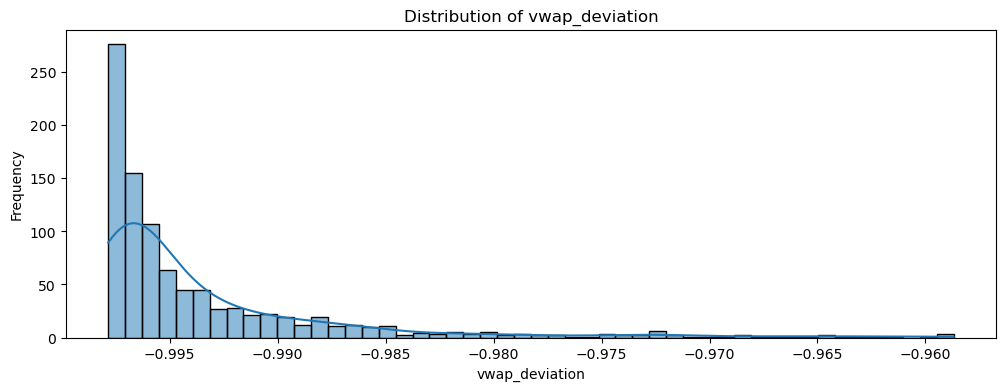

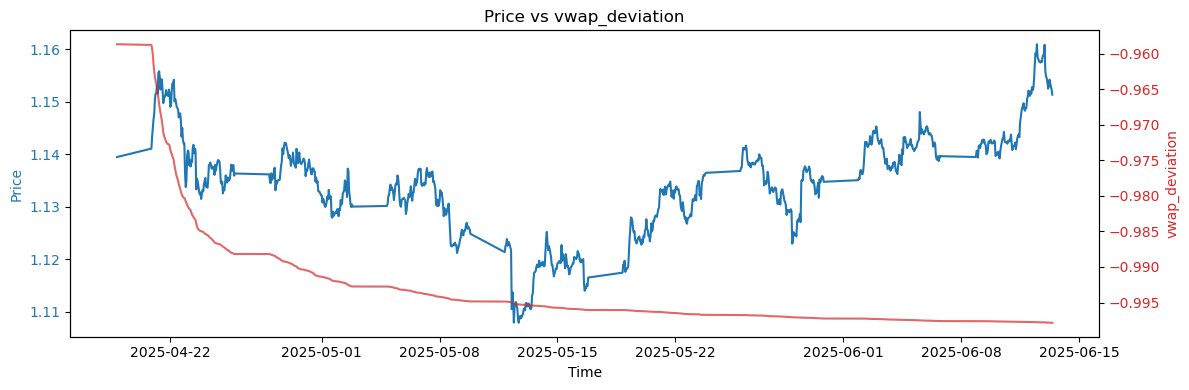

Correlation between vwap_deviation and future price move: 0.0107

📊 Analyzing: rsi


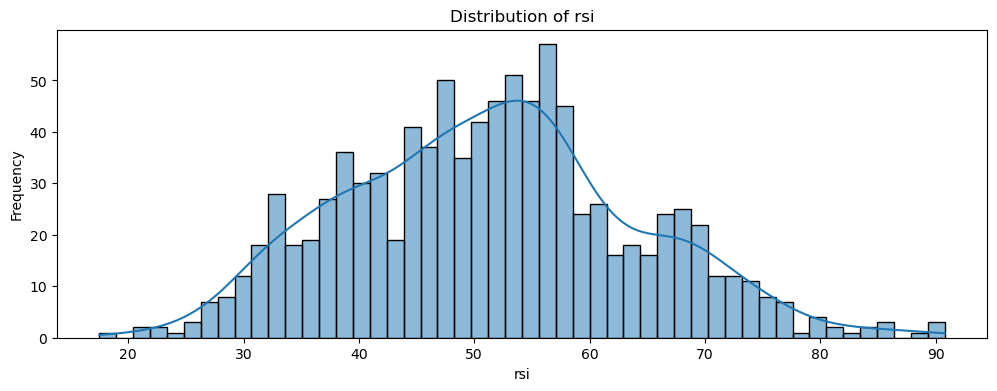

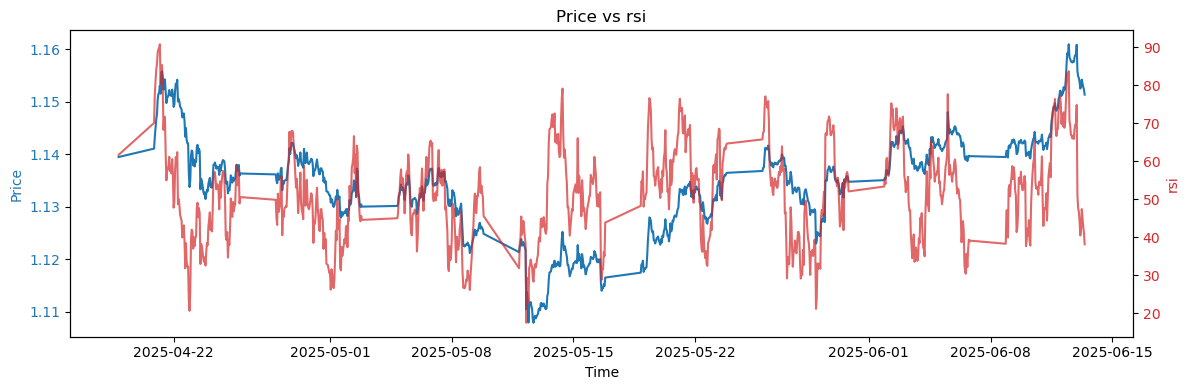

Correlation between rsi and future price move: -0.0003

📊 Analyzing: z_score_vwap


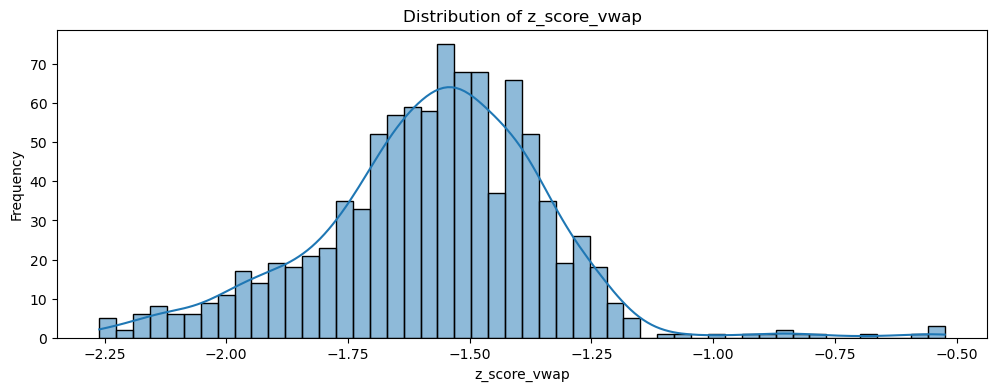

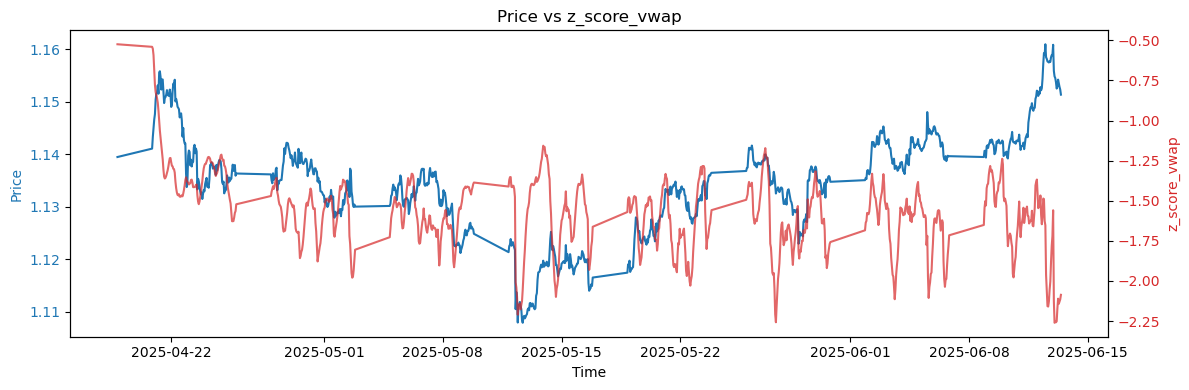

Correlation between z_score_vwap and future price move: 0.0590

📊 Analyzing: rsi_slope


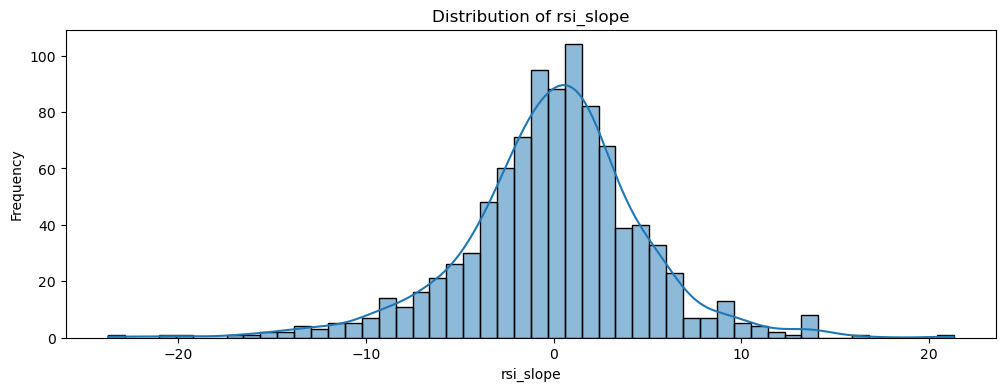

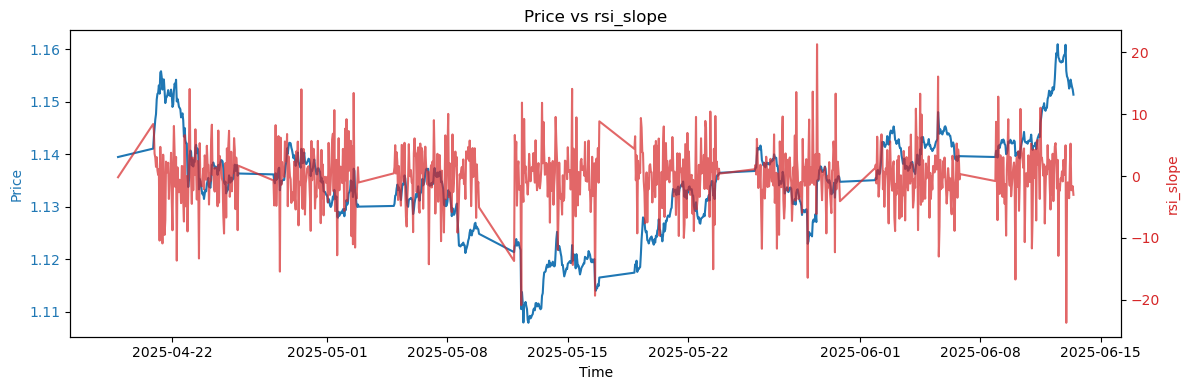

Correlation between rsi_slope and future price move: -0.0349

📊 Analyzing: roc


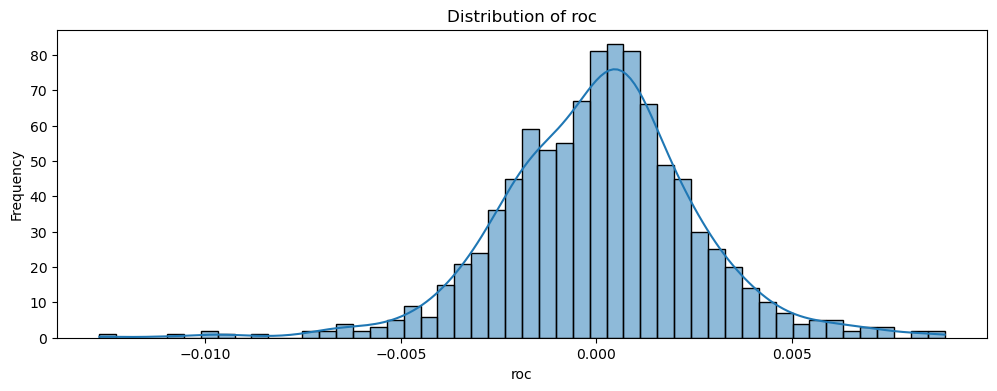

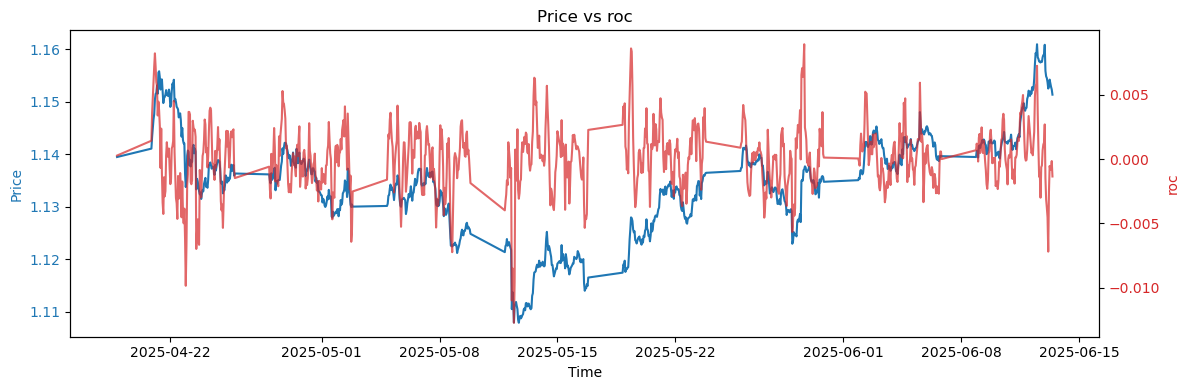

Correlation between roc and future price move: -0.0193

📊 Analyzing: momentum


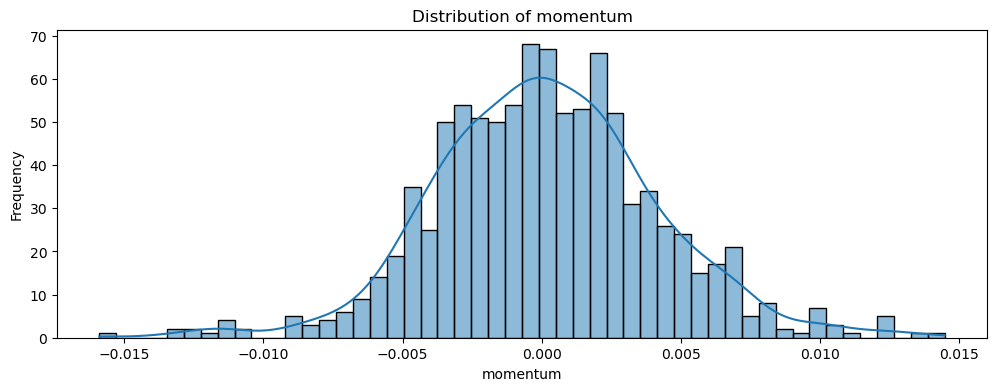

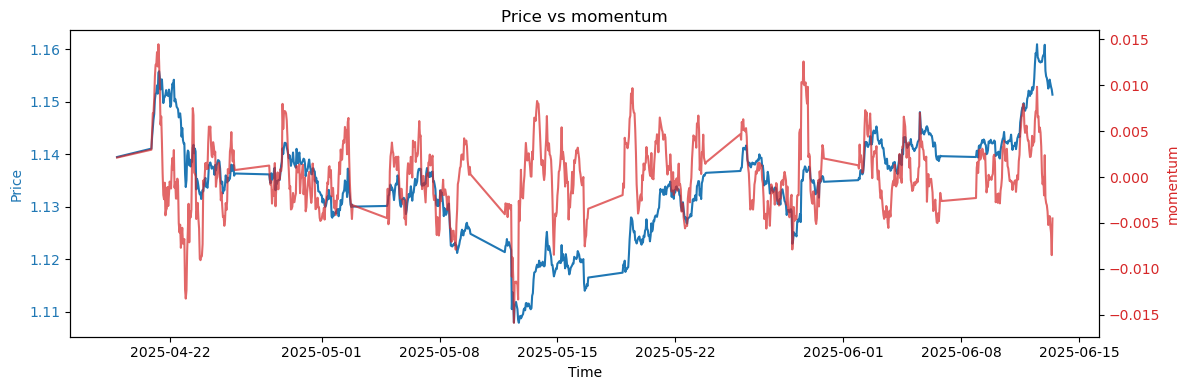

Correlation between momentum and future price move: 0.0245

📊 Analyzing: atr


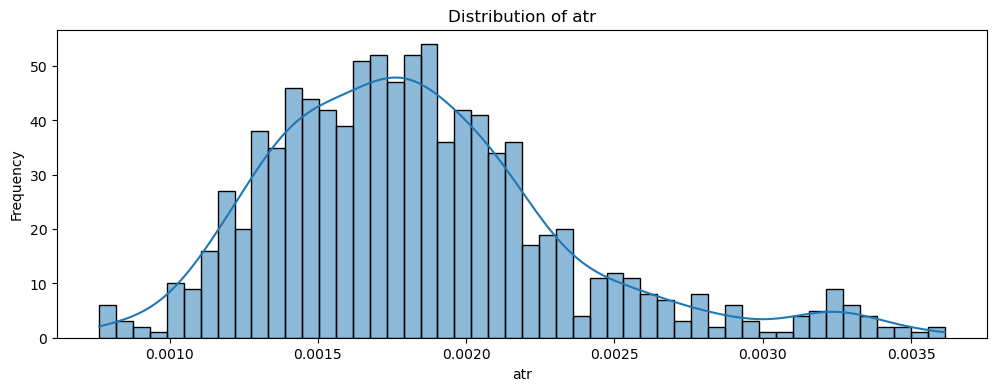

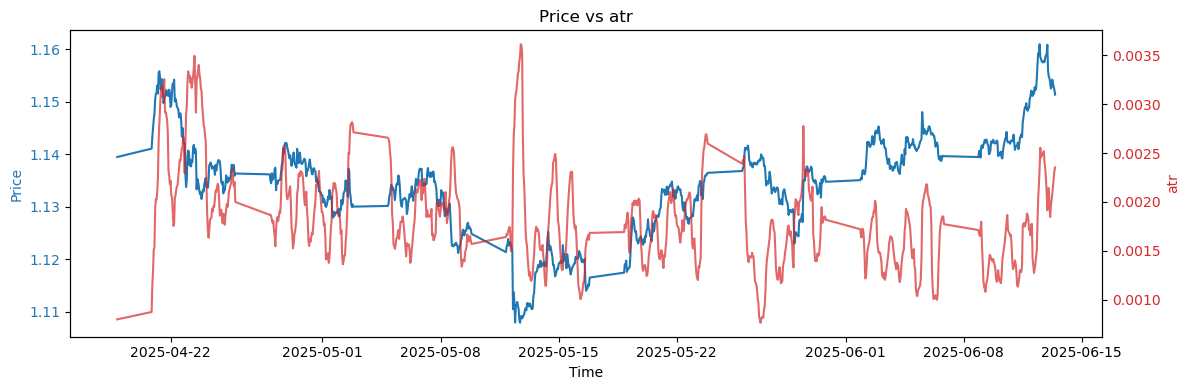

Correlation between atr and future price move: -0.0402

📊 Analyzing: volatility


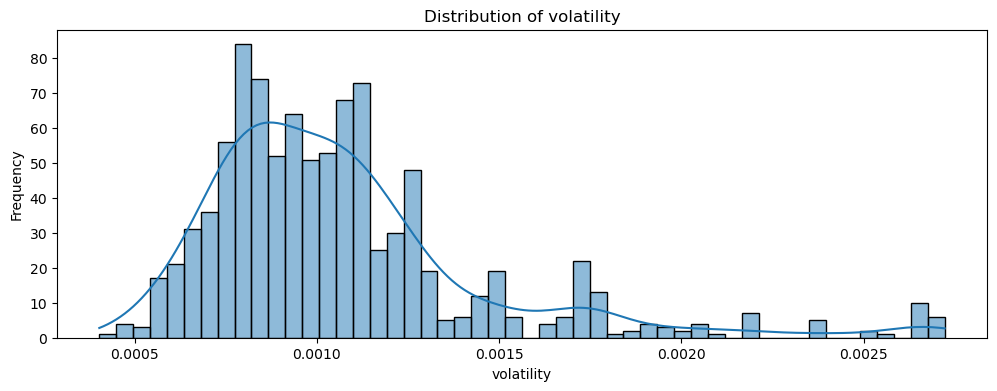

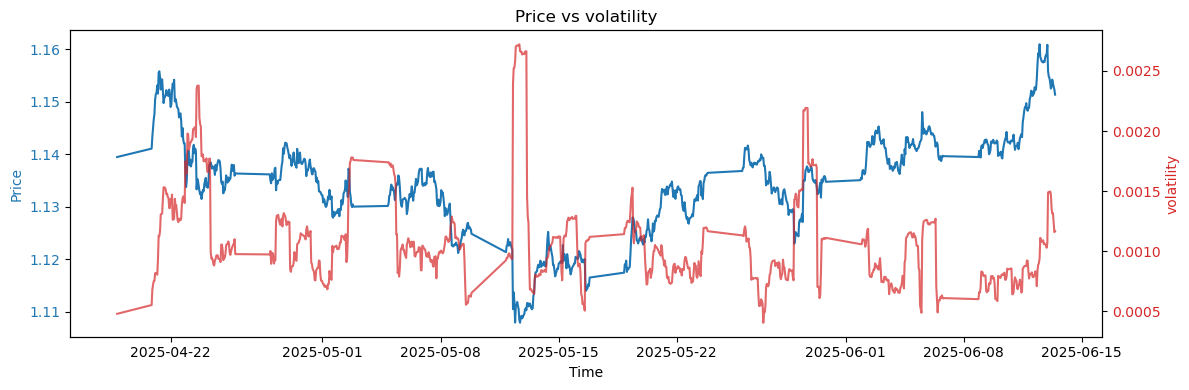

Correlation between volatility and future price move: -0.0050

📊 Analyzing: candle_body


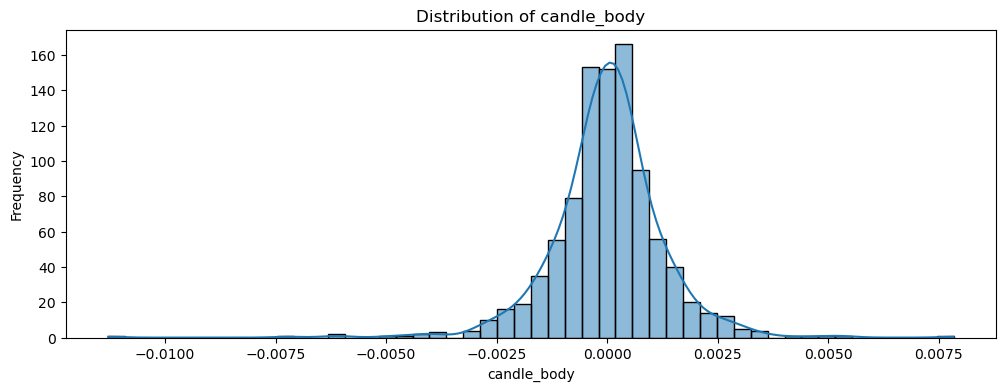

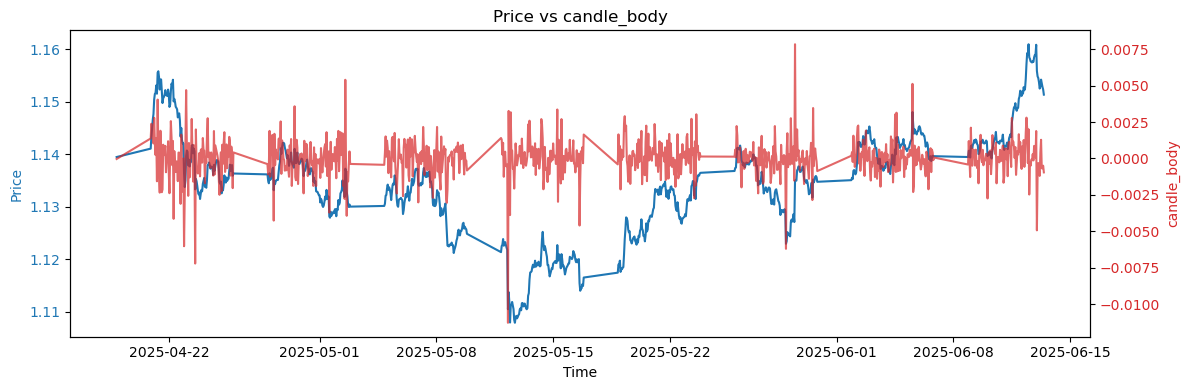

Correlation between candle_body and future price move: -0.0448

📊 Analyzing: wick_upper


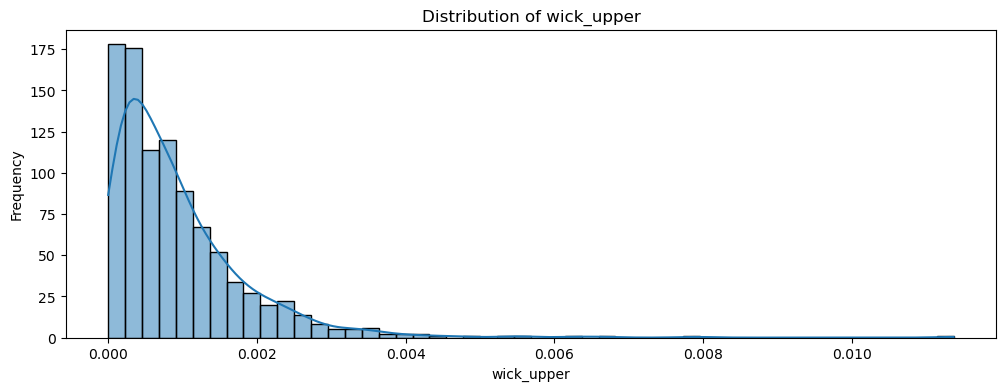

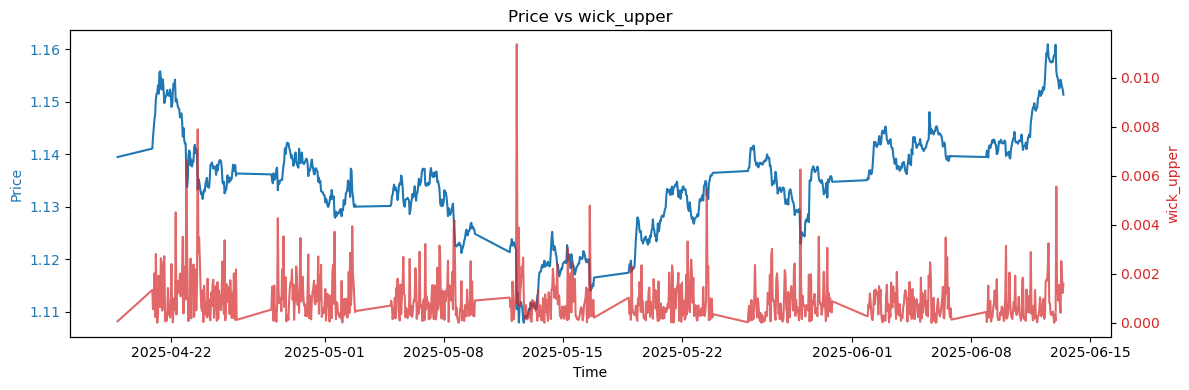

Correlation between wick_upper and future price move: 0.0399

📊 Analyzing: wick_lower


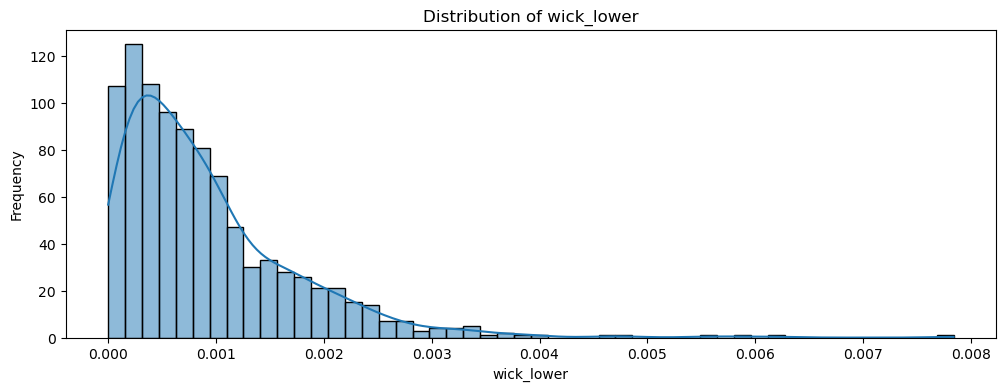

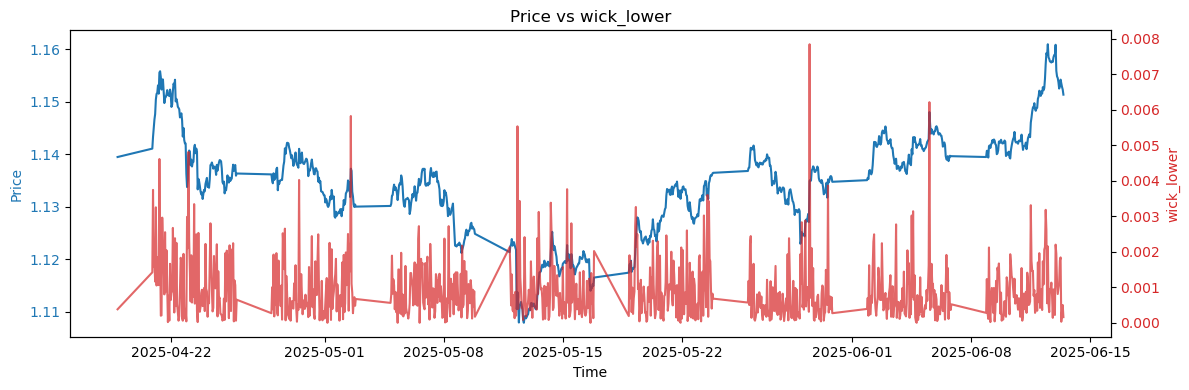

Correlation between wick_lower and future price move: -0.0230

📊 Analyzing: volume_deviation


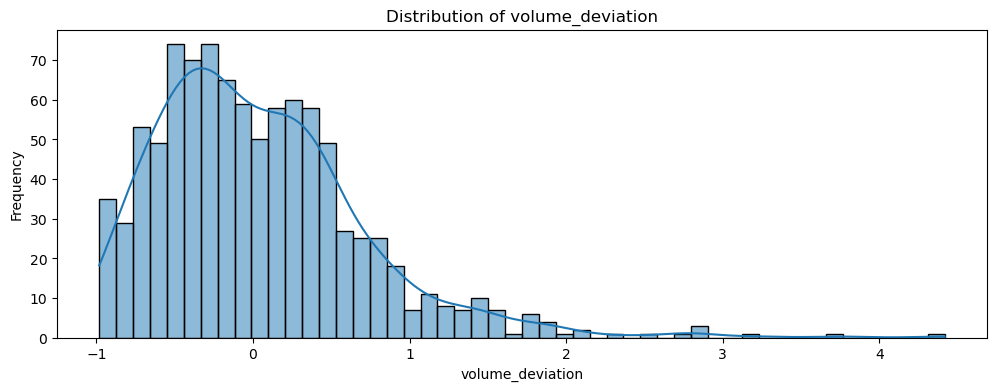

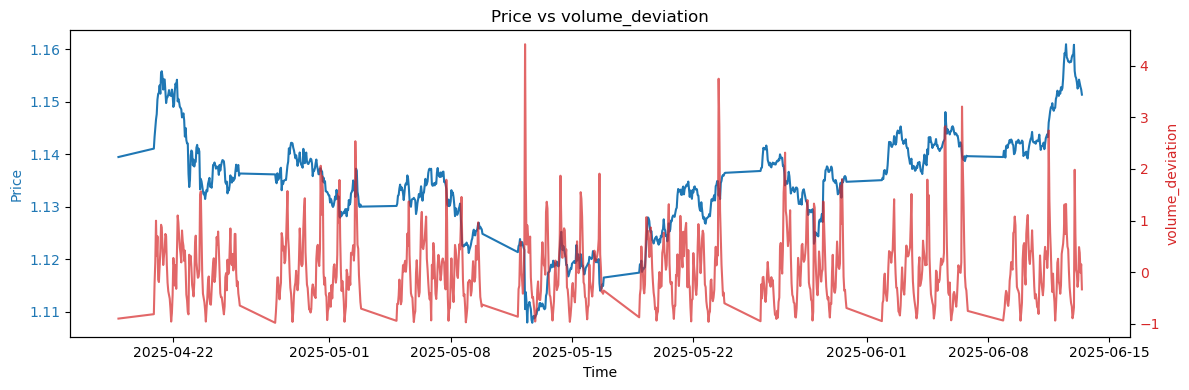

Correlation between volume_deviation and future price move: -0.0206

✅ Feature analysis complete. Ready for next step.


In [3]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # --- Trend & Mean Reversion ---
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']

    df['rsi'] = ta.rsi(df['close'], length=14)
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # --- Momentum ---
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    macd = ta.macd(df['close'])
    df['macd_line'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = macd['MACDh_12_26_9']

    # --- Volatility ---
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()

    df['volatility'] = df['close'].pct_change().rolling(20).std()

    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # --- Volume ---
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    # Drop missing values
    df = df.dropna()
    return df

# =============================
# 3. Feature Analysis Functions
# =============================
def analyze_feature_distribution(df, feature_col):
    plt.figure(figsize=(12, 4))
    sns.histplot(df[feature_col], kde=True, bins=50)
    plt.title(f"Distribution of {feature_col}")
    plt.xlabel(feature_col)
    plt.ylabel("Frequency")
    plt.show()

def analyze_feature_vs_price(df, feature_col):
    fig, ax1 = plt.subplots(figsize=(12, 4))

    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price', color=color)
    ax1.plot(df['close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(feature_col, color=color)
    ax2.plot(df[feature_col], color=color, alpha=0.7, label=feature_col)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f"Price vs {feature_col}")
    plt.tight_layout()
    plt.show()

def analyze_feature_correlation(df, feature_col, target_col='close', look_ahead=1):
    # Calculate future move
    df['target_future'] = df[target_col].shift(-look_ahead)
    df['target_move'] = df['target_future'] / df[target_col] - 1

    # Drop NaNs before correlation
    clean_df = df[[feature_col, 'target_move']].dropna()

    if len(clean_df) < 5:
        print(f"⚠️ Not enough data to compute correlation for {feature_col}")
        return np.nan

    corr = np.corrcoef(clean_df[feature_col], clean_df['target_move'])[0][1]
    print(f"Correlation between {feature_col} and future price move: {corr:.4f}")
    return corr

def analyze_all_features(df):
    features = [
        'vwap_deviation',
        'rsi',
        'z_score_vwap',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    for feature in features:
        if feature not in df.columns:
            print(f"⚠️ Feature '{feature}' not found. Skipping.")
            continue
        print(f"\n📊 Analyzing: {feature}")
        analyze_feature_distribution(df, feature)
        analyze_feature_vs_price(df, feature)
        analyze_feature_correlation(df, feature)

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🔍 Feature Analysis...\n")
    analyze_all_features(df)

    print("\n✅ Feature analysis complete. Ready for next step.")

📥 Fetching data...

🛠 Feature Engineering...

🎯 Feature Analysis Based on Objective: Will Price Revert Toward VWAP?

📊 Analyzing: vwap_deviation
Class 0 (no reversion): mean=-0.9978, std=0.0000, count=5
Class 1 (reversion):     mean=-0.9935, std=0.0064, count=946
T-statistic: -21.0509 | p-value: 0.0000
✅ Strong separation — this feature helps!


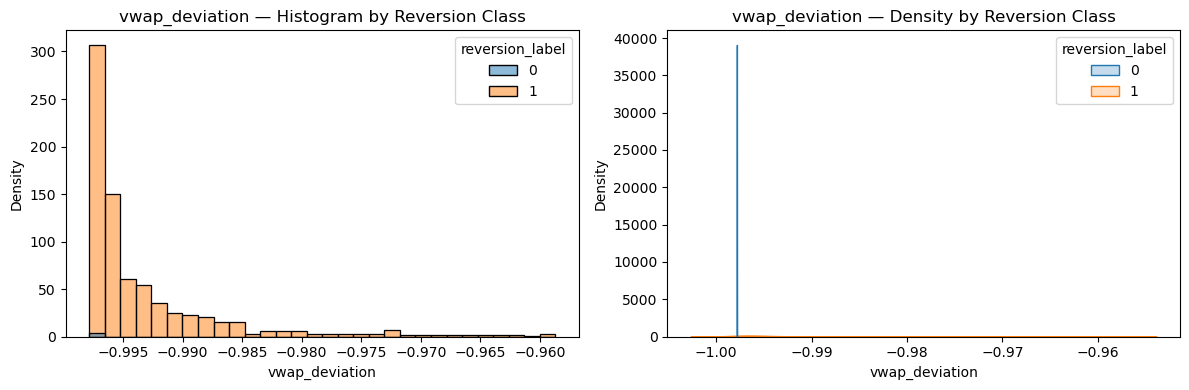


📊 Analyzing: z_score_vwap
Class 0 (no reversion): mean=-2.1329, std=0.0234, count=5
Class 1 (reversion):     mean=-1.5754, std=0.2316, count=946
T-statistic: -43.2223 | p-value: 0.0000
✅ Strong separation — this feature helps!


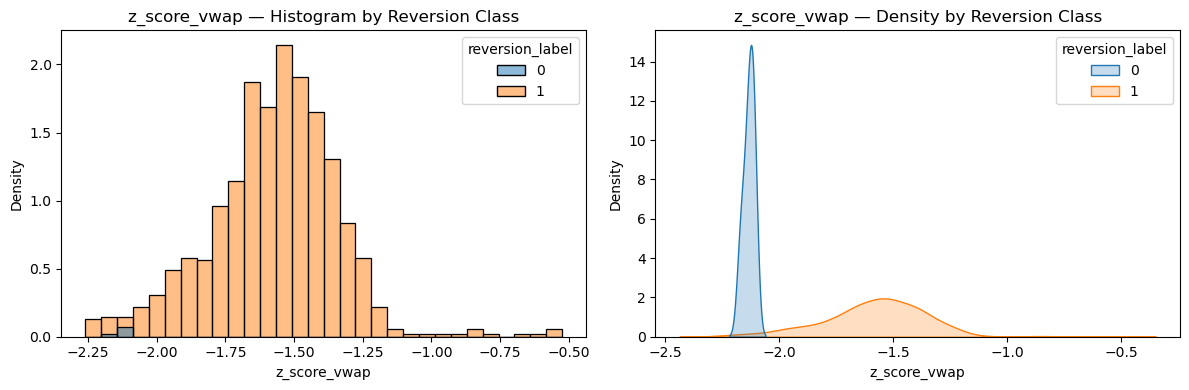


📊 Analyzing: rsi
Class 0 (no reversion): mean=42.4459, std=4.4539, count=5
Class 1 (reversion):     mean=51.4212, std=12.5032, count=946
T-statistic: -4.4150 | p-value: 0.0096
✅ Strong separation — this feature helps!


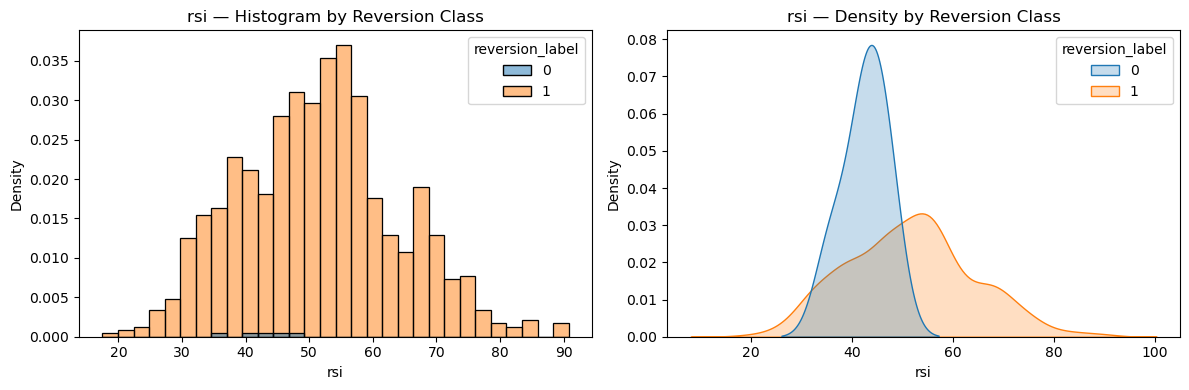


📊 Analyzing: rsi_slope
Class 0 (no reversion): mean=-1.3007, std=3.9536, count=5
Class 1 (reversion):     mean=-0.0208, std=4.7896, count=946
T-statistic: -0.7211 | p-value: 0.5102
➡️ Small separation


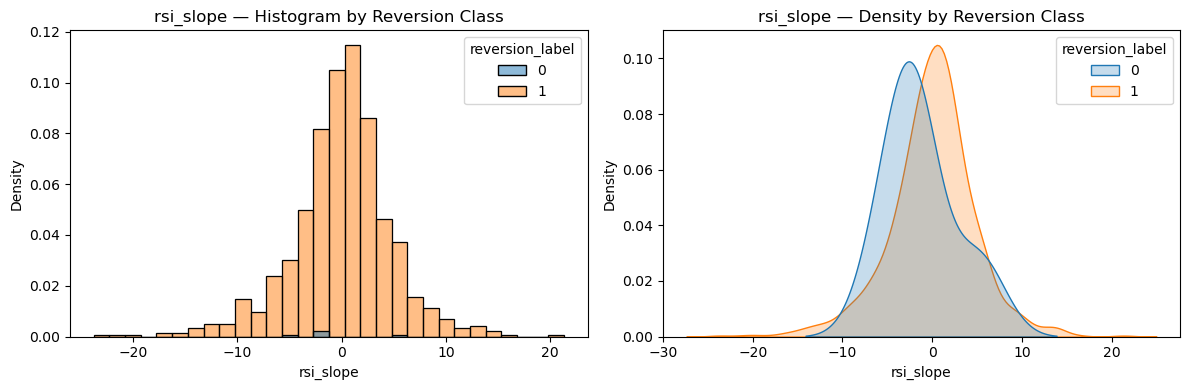


📊 Analyzing: roc
Class 0 (no reversion): mean=-0.0009, std=0.0008, count=5
Class 1 (reversion):     mean=0.0001, std=0.0025, count=946
T-statistic: -2.7631 | p-value: 0.0447
➡️ Moderate separation


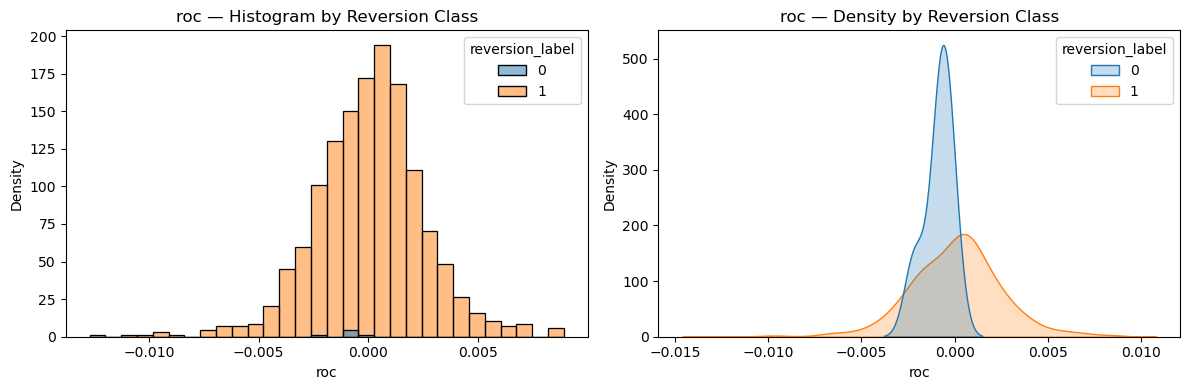


📊 Analyzing: momentum
Class 0 (no reversion): mean=-0.0059, std=0.0016, count=5
Class 1 (reversion):     mean=0.0002, std=0.0040, count=946
T-statistic: -8.4778 | p-value: 0.0008
✅ Strong separation — this feature helps!


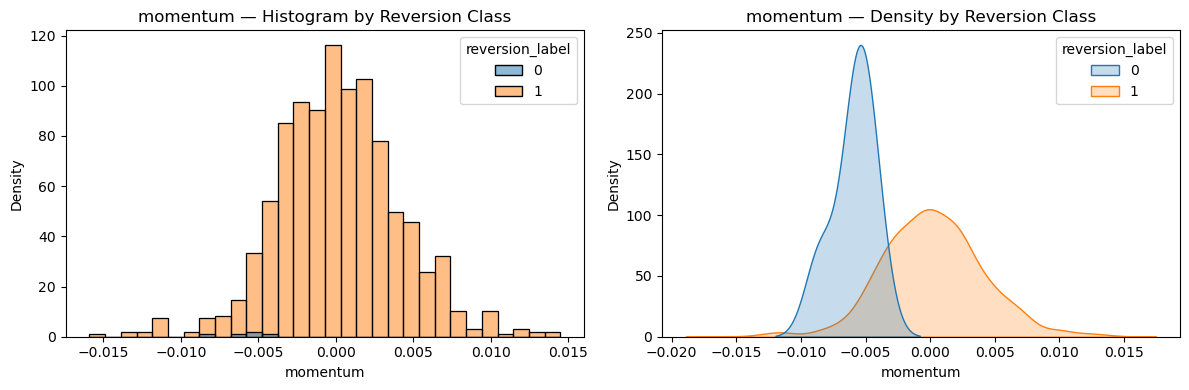


📊 Analyzing: atr
Class 0 (no reversion): mean=0.0023, std=0.0002, count=5
Class 1 (reversion):     mean=0.0018, std=0.0005, count=946
T-statistic: 5.5932 | p-value: 0.0038
✅ Strong separation — this feature helps!


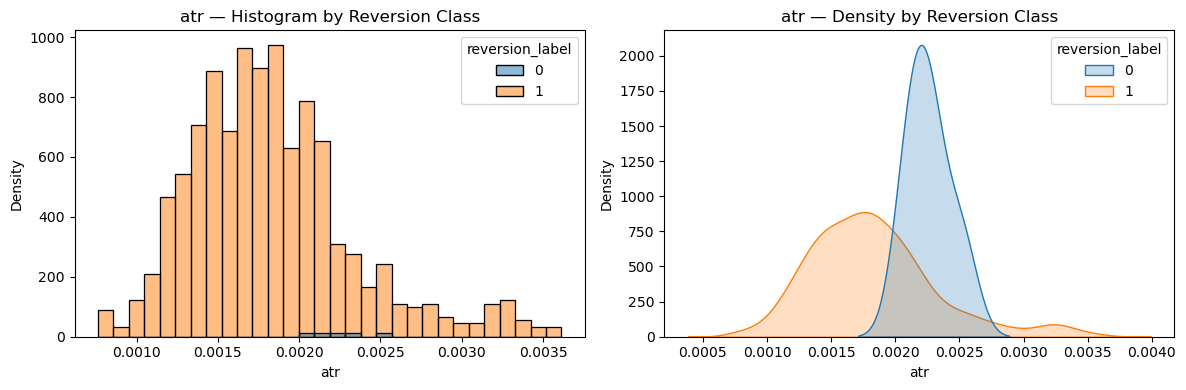


📊 Analyzing: volatility
Class 0 (no reversion): mean=0.0012, std=0.0001, count=5
Class 1 (reversion):     mean=0.0011, std=0.0004, count=946
T-statistic: 5.1407 | p-value: 0.0027
➡️ Moderate separation


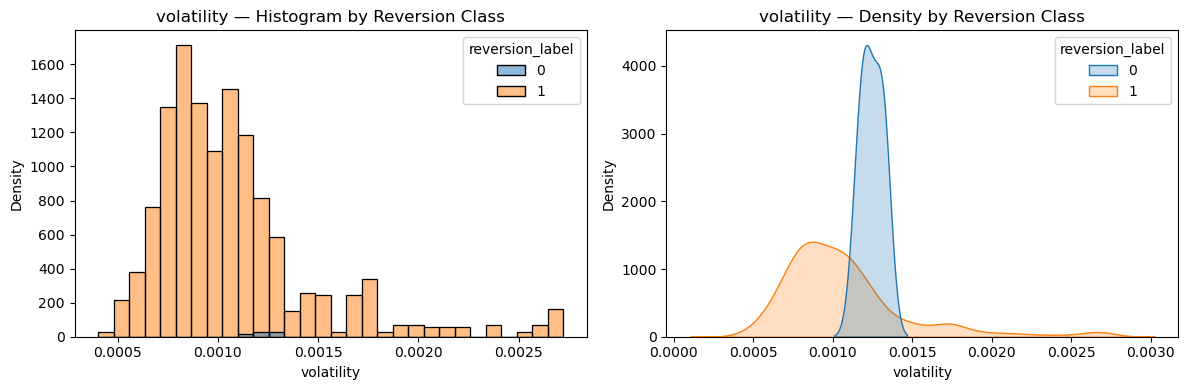


📊 Analyzing: candle_body
Class 0 (no reversion): mean=-0.0005, std=0.0011, count=5
Class 1 (reversion):     mean=0.0000, std=0.0013, count=946
T-statistic: -0.9913 | p-value: 0.3769
➡️ Small separation


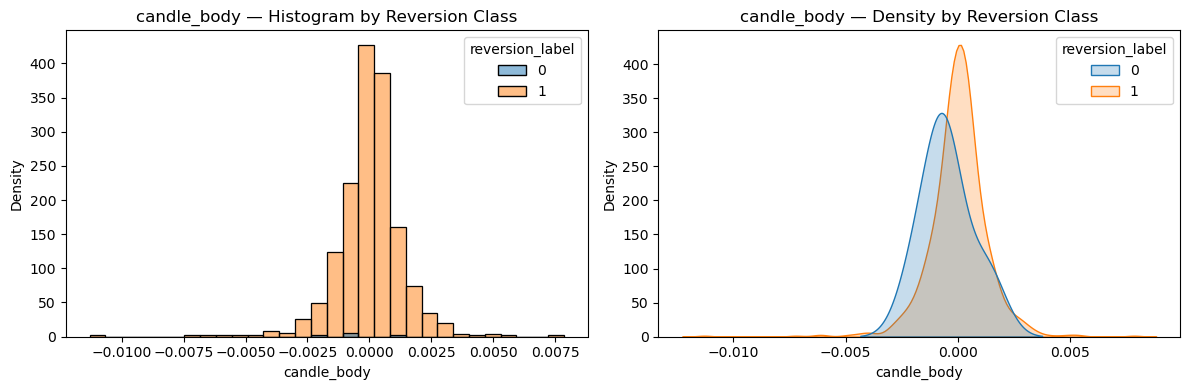


📊 Analyzing: wick_upper
Class 0 (no reversion): mean=0.0017, std=0.0009, count=5
Class 1 (reversion):     mean=0.0009, std=0.0009, count=946
T-statistic: 1.9156 | p-value: 0.1271
✅ Strong separation — this feature helps!


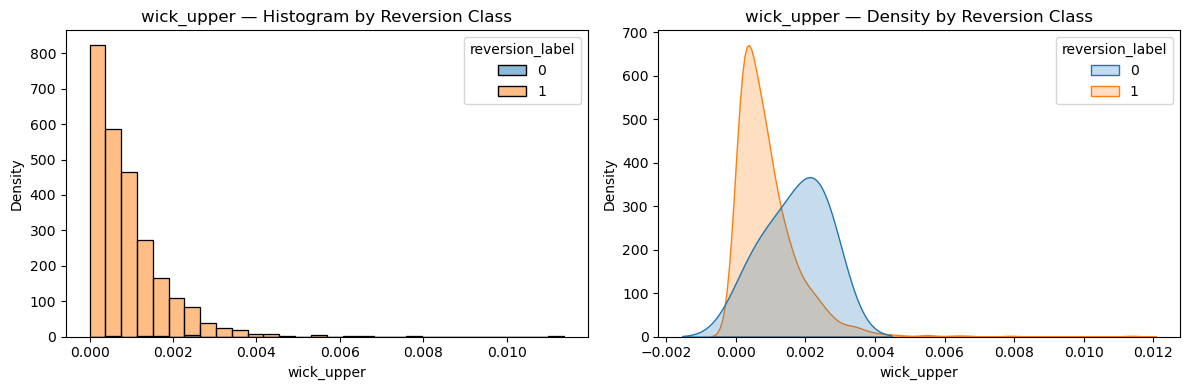


📊 Analyzing: wick_lower
Class 0 (no reversion): mean=0.0009, std=0.0008, count=5
Class 1 (reversion):     mean=0.0009, std=0.0008, count=946
T-statistic: -0.1678 | p-value: 0.8748
➡️ Very weak separation (Cohen's d < 0.2)


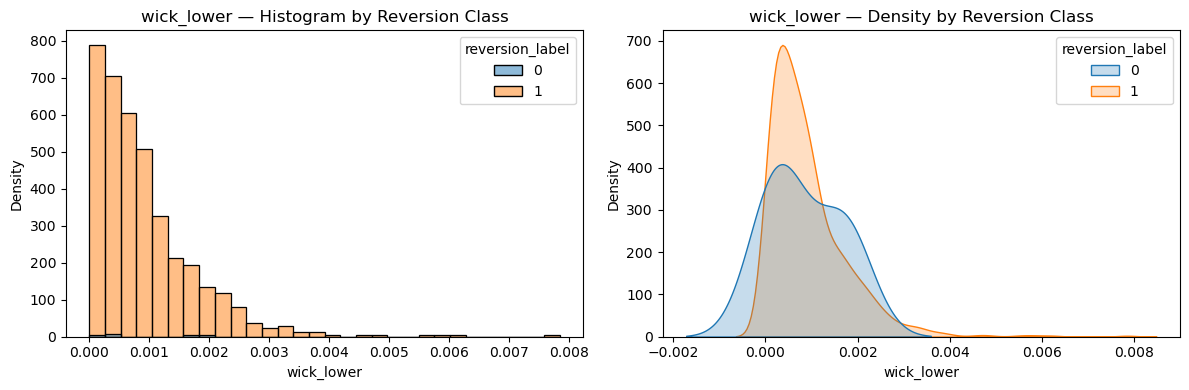


📊 Analyzing: volume_deviation
Class 0 (no reversion): mean=0.2525, std=0.1920, count=5
Class 1 (reversion):     mean=0.0355, std=0.6701, count=946
T-statistic: 2.4498 | p-value: 0.0631
➡️ Small separation


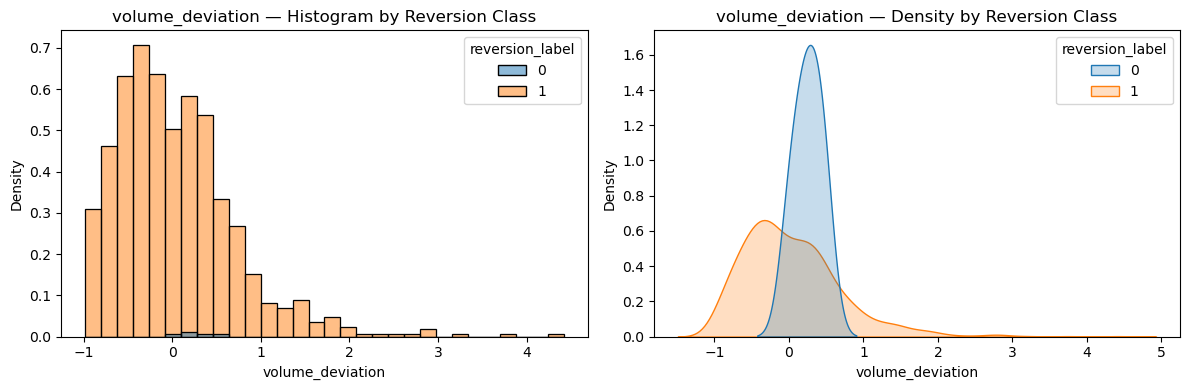



🧠 FINAL VERDICT:
✅ These features show meaningful separation: ['vwap_deviation', 'z_score_vwap', 'rsi', 'roc', 'momentum', 'atr', 'volatility']
Model has a chance to learn from them.

📊 Summary of Feature Quality:
             feature  mean_diff  std_combined  effect_size       p_value  \
1       z_score_vwap   0.557464      0.164569     3.387423  6.188227e-12   
5           momentum   0.006121      0.003023     2.024657  7.932929e-04   
6                atr   0.000433      0.000374     1.156896  3.813782e-03   
0     vwap_deviation   0.004370      0.004514     0.968074  5.555091e-81   
2                rsi   8.975328      9.385305     0.956317  9.605494e-03   
9         wick_upper   0.000774      0.000923     0.838329  1.270941e-01   
7         volatility   0.000173      0.000286     0.605346  2.748733e-03   
4                roc   0.000959      0.001860     0.515568  4.465931e-02   
11  volume_deviation   0.217000      0.492863     0.440284  6.309193e-02   
8        candle_body   0

In [5]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
from scipy.stats import ttest_ind

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # --- Trend & Mean Reversion ---
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # --- Momentum ---
    df['rsi'] = ta.rsi(df['close'], length=14)
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    macd = ta.macd(df['close'])
    df['macd_line'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = macd['MACDh_12_26_9']

    # --- Volatility ---
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # --- Volume ---
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    # Drop missing values
    df = df.dropna()
    return df

# =============================
# 3. Labeling for Mean Reversion
# =============================
def create_mean_reversion_label(df, look_forward=5):
    """
    Label = 1 if price reverted back to VWAP in next N candles.
    Label = 0 otherwise.
    """
    df = df.copy()
    df['reversion_label'] = np.where(df['close'].shift(-look_forward) < df['vwap'], 1, 0)
    df['reversion_label'] = df['reversion_label'].fillna(0).astype(int)
    return df

# =============================
# 4. Analyze Features vs Label
# =============================
def analyze_feature_for_objective(df, feature_col):
    if feature_col not in df.columns:
        print(f"⚠️ Feature '{feature_col}' not found. Skipping.")
        return

    # New label
    df = create_mean_reversion_label(df)

    clean_df = df[[feature_col, 'reversion_label']].dropna()
    group0 = clean_df[clean_df['reversion_label'] == 0][feature_col]
    group1 = clean_df[clean_df['reversion_label'] == 1][feature_col]

    print(f"\n📊 Analyzing: {feature_col}")
    print(f"Class 0 (no reversion): mean={group0.mean():.4f}, std={group0.std():.4f}, count={len(group0)}")
    print(f"Class 1 (reversion):     mean={group1.mean():.4f}, std={group1.std():.4f}, count={len(group1)}")

    # T-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-statistic: {t_stat:.4f} | p-value: {p_val:.4f}")

    # Effect size
    combined_std = np.sqrt((group0.std()**2 + group1.std()**2) / 2)
    effect_size = abs(group1.mean() - group0.mean()) / combined_std
    if effect_size < 0.2:
        print("➡️ Very weak separation (Cohen's d < 0.2)")
    elif effect_size < 0.5:
        print("➡️ Small separation")
    elif effect_size < 0.8:
        print("➡️ Moderate separation")
    else:
        print("✅ Strong separation — this feature helps!")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data=clean_df, x=feature_col, hue='reversion_label', bins=30, stat="density")
    plt.title(f"{feature_col} — Histogram by Reversion Class")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=clean_df, x=feature_col, hue='reversion_label', fill=True, common_norm=False)
    plt.title(f"{feature_col} — Density by Reversion Class")

    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_col,
        'mean_diff': abs(group1.mean() - group0.mean()),
        'std_combined': combined_std,
        'effect_size': effect_size,
        'p_value': p_val,
        'significant': p_val < 0.05 and effect_size > 0.2
    }

# =============================
# 5. Run All Analyses
# =============================
def analyze_all_features(df):
    features = [
        'vwap_deviation',
        'z_score_vwap',
        'rsi',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    results = []
    for feature in features:
        result = analyze_feature_for_objective(df, feature)
        results.append(result)

    result_df = pd.DataFrame(results)
    significant_features = result_df[result_df['significant']]['feature'].tolist()

    print("\n\n🧠 FINAL VERDICT:")
    if len(significant_features) >= 1:
        print(f"✅ These features show meaningful separation: {significant_features}")
        print("Model has a chance to learn from them.")
    else:
        print("❌ No feature shows clear separation. Need better engineering or labeling.")

    return result_df

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🎯 Feature Analysis Based on Objective: Will Price Revert Toward VWAP?")
    result_df = analyze_all_features(df)

    print("\n📊 Summary of Feature Quality:")
    print(result_df.sort_values(by='effect_size', ascending=False))

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier Method...

📊 Feature Analysis Based on Objective

📊 Analyzing: vwap_deviation
Class 0 (no TP): mean=-0.9936, std=0.0060, count=921
Class 1 (TP):     mean=-0.9907, std=0.0130, count=30
T-statistic: -1.2221 | p-value: 0.2314
➡️ Small separation


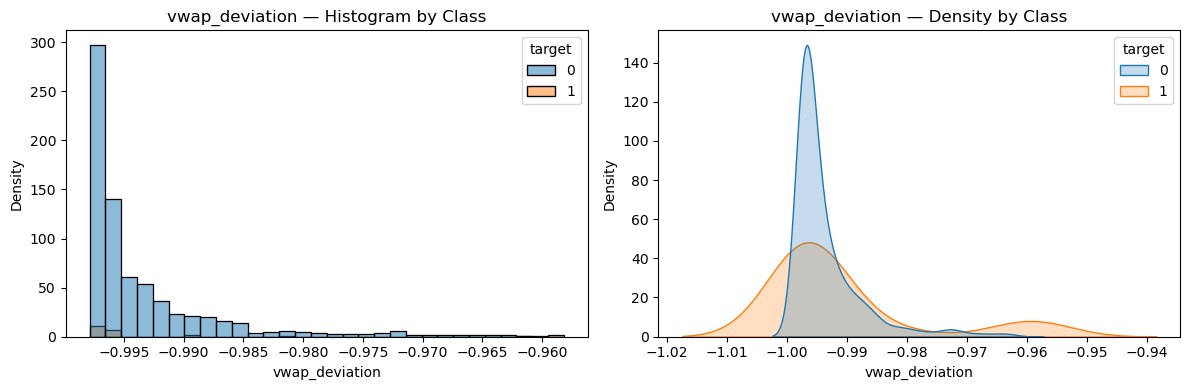


📊 Analyzing: z_score_vwap
Class 0 (no TP): mean=-1.5856, std=0.2256, count=921
Class 1 (TP):     mean=-1.4002, std=0.3486, count=30
T-statistic: -2.8940 | p-value: 0.0070
➡️ Moderate separation


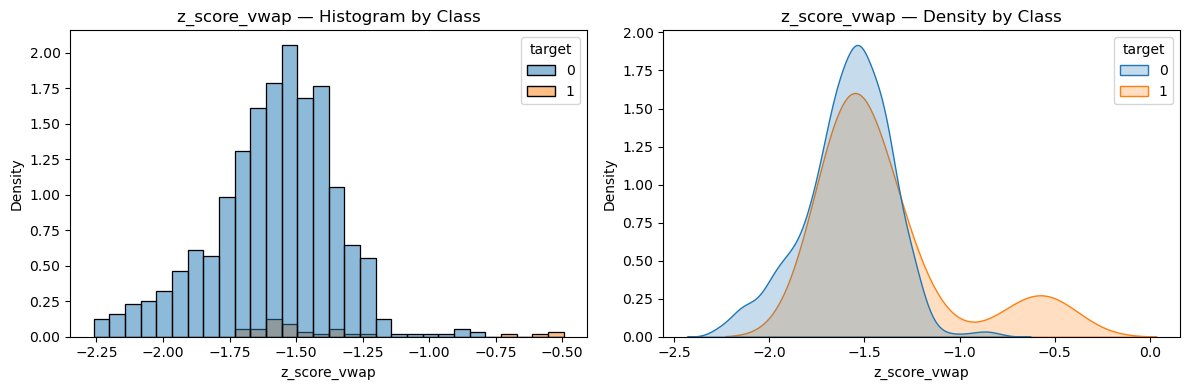


📊 Analyzing: rsi
Class 0 (no TP): mean=51.1509, std=12.4123, count=921
Class 1 (TP):     mean=57.2074, std=13.5718, count=30
T-statistic: -2.4116 | p-value: 0.0221
➡️ Small separation


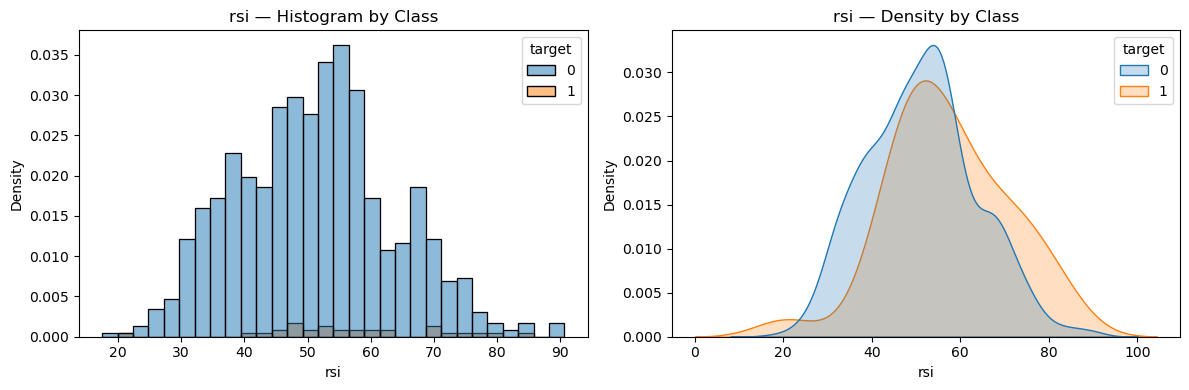


📊 Analyzing: rsi_slope
Class 0 (no TP): mean=-0.0630, std=4.8152, count=921
Class 1 (TP):     mean=1.0964, std=3.6465, count=30
T-statistic: -1.6941 | p-value: 0.0998
➡️ Small separation


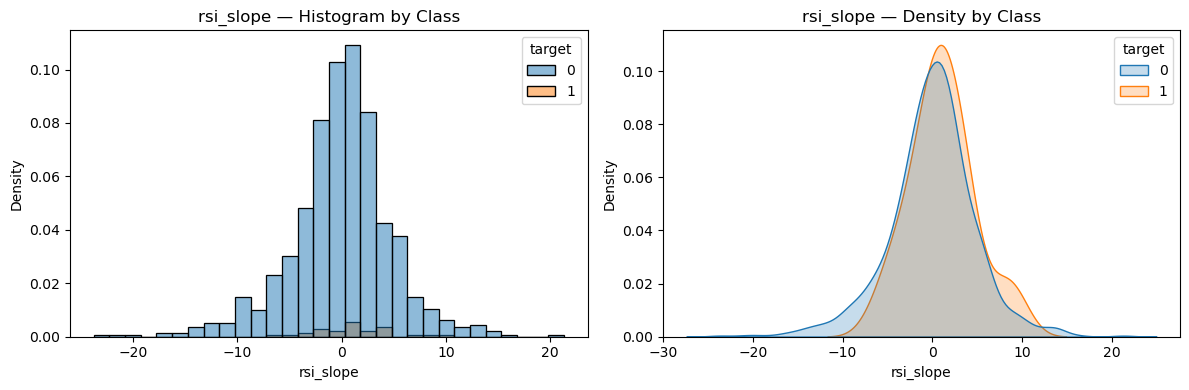


📊 Analyzing: roc
Class 0 (no TP): mean=0.0000, std=0.0025, count=921
Class 1 (TP):     mean=0.0009, std=0.0027, count=30
T-statistic: -1.7423 | p-value: 0.0915
➡️ Small separation


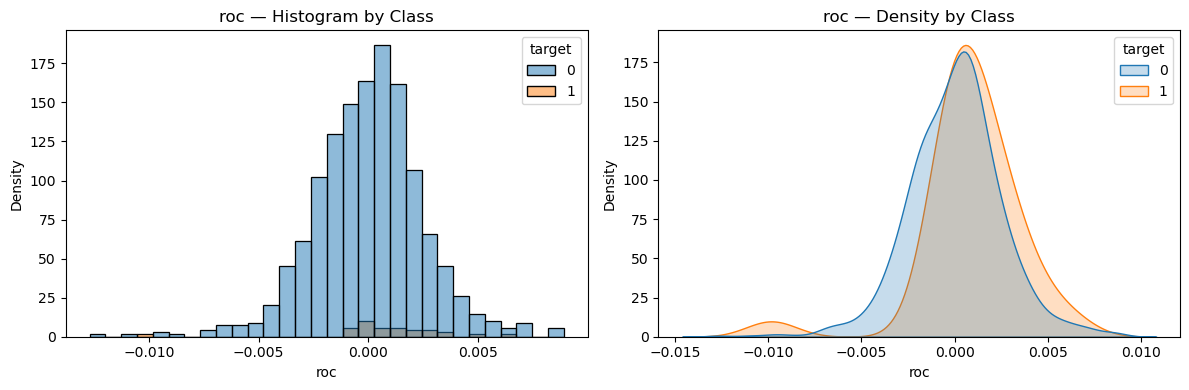


📊 Analyzing: momentum
Class 0 (no TP): mean=0.0001, std=0.0040, count=921
Class 1 (TP):     mean=0.0016, std=0.0038, count=30
T-statistic: -2.1915 | p-value: 0.0360
➡️ Small separation


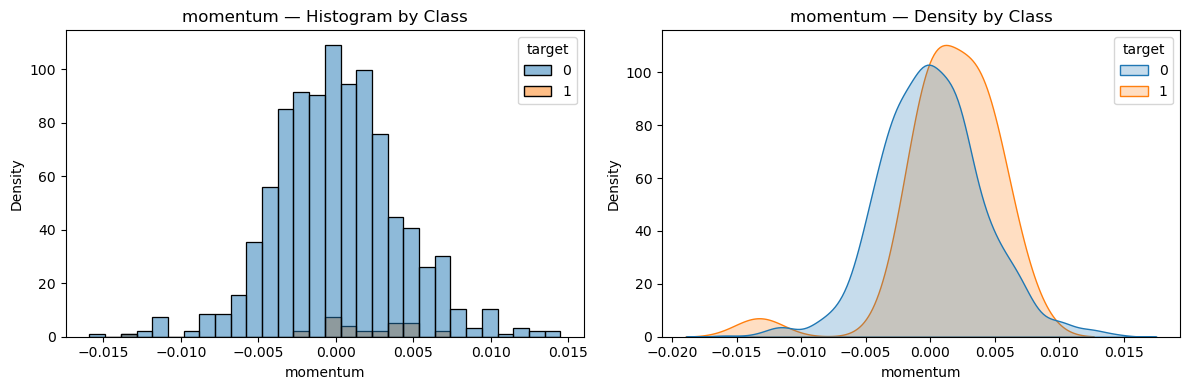


📊 Analyzing: atr
Class 0 (no TP): mean=0.0018, std=0.0005, count=921
Class 1 (TP):     mean=0.0016, std=0.0004, count=30
T-statistic: 3.5568 | p-value: 0.0012
➡️ Moderate separation


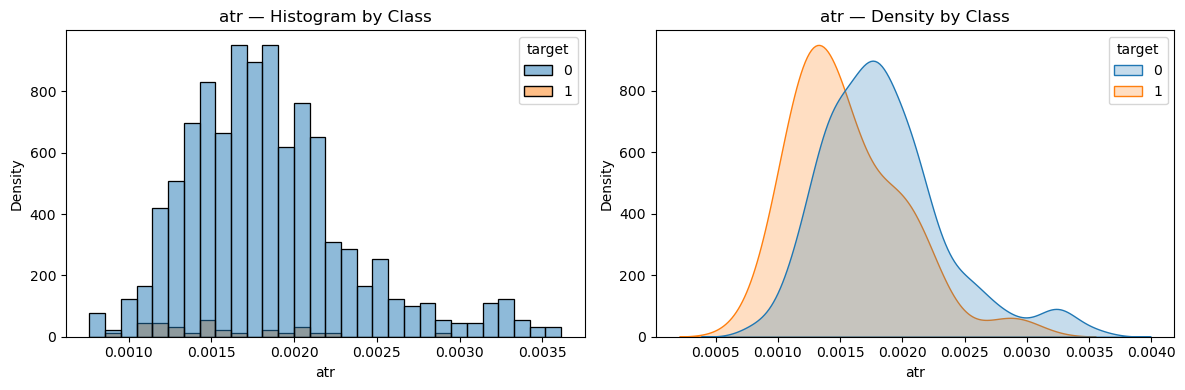


📊 Analyzing: volatility
Class 0 (no TP): mean=0.0011, std=0.0004, count=921
Class 1 (TP):     mean=0.0010, std=0.0003, count=30
T-statistic: 0.4771 | p-value: 0.6365
➡️ Very weak separation (Cohen's d < 0.2)


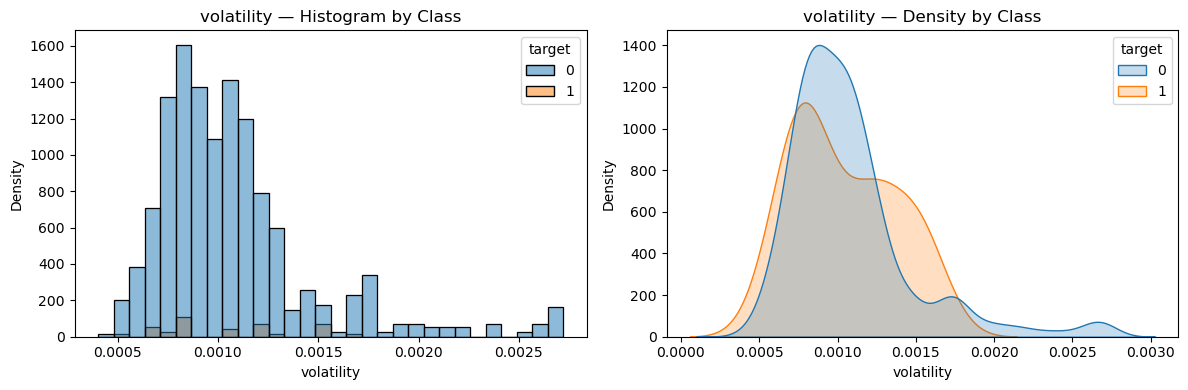


📊 Analyzing: candle_body
Class 0 (no TP): mean=-0.0000, std=0.0013, count=921
Class 1 (TP):     mean=0.0003, std=0.0011, count=30
T-statistic: -1.6098 | p-value: 0.1173
➡️ Small separation


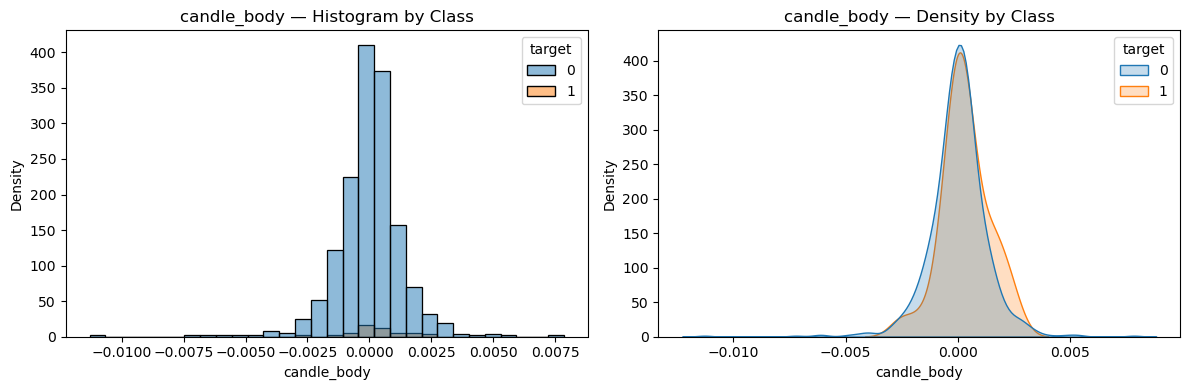


📊 Analyzing: wick_upper
Class 0 (no TP): mean=0.0009, std=0.0010, count=921
Class 1 (TP):     mean=0.0008, std=0.0007, count=30
T-statistic: 0.7908 | p-value: 0.4348
➡️ Very weak separation (Cohen's d < 0.2)


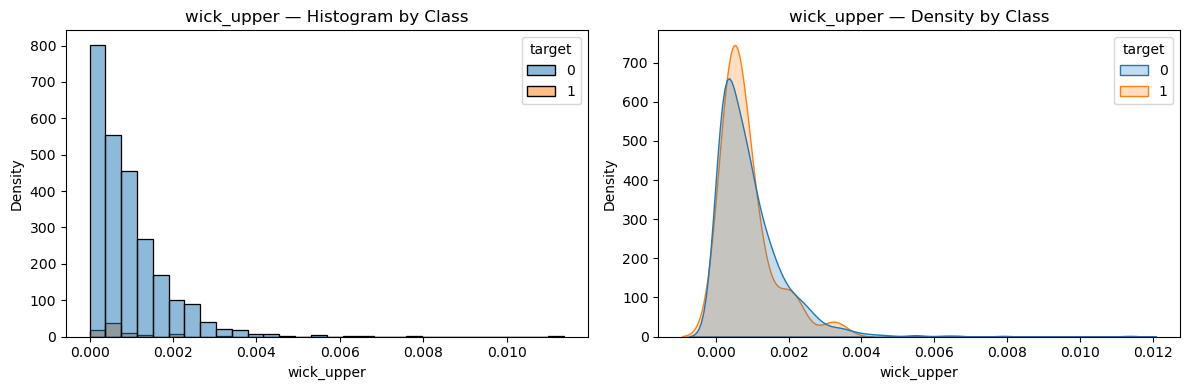


📊 Analyzing: wick_lower
Class 0 (no TP): mean=0.0009, std=0.0008, count=921
Class 1 (TP):     mean=0.0011, std=0.0009, count=30
T-statistic: -1.0795 | p-value: 0.2888
➡️ Small separation


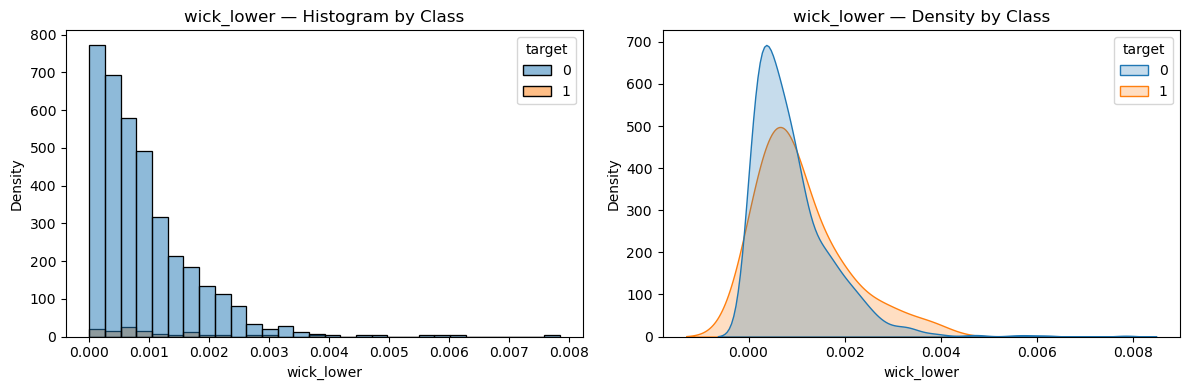


📊 Analyzing: volume_deviation
Class 0 (no TP): mean=0.0380, std=0.6750, count=921
Class 1 (TP):     mean=0.0264, std=0.3985, count=30
T-statistic: 0.1527 | p-value: 0.8796
➡️ Very weak separation (Cohen's d < 0.2)


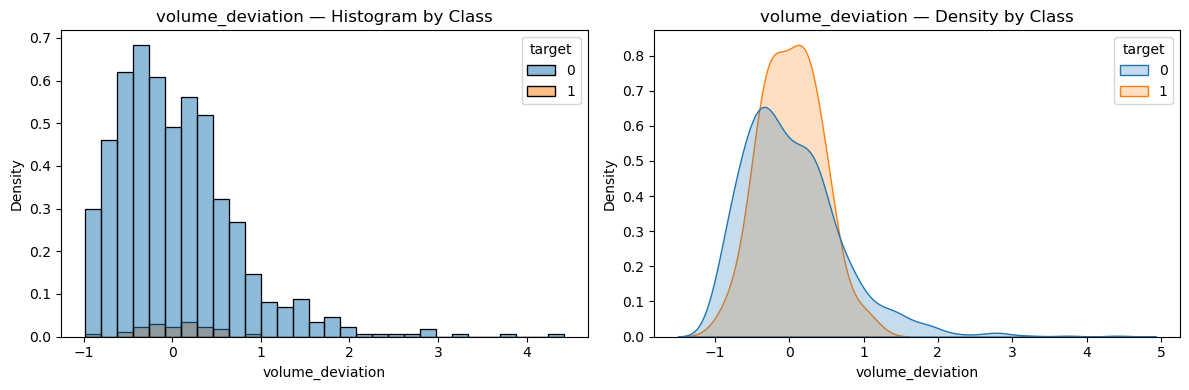


🧠 FINAL VERDICT:
✅ These features show meaningful separation: ['z_score_vwap', 'rsi', 'momentum', 'atr']
Model has a chance to learn.

📈 Label Distribution After Triple Barrier
target
0    0.968454
1    0.031546
Name: proportion, dtype: float64

📊 Summary of Feature Quality:
             feature  effect_size  significant
1       z_score_vwap     0.631572         True
6                atr     0.618322         True
2                rsi     0.465702         True
5           momentum     0.394945         True
4                roc     0.332765        False
0     vwap_deviation     0.287529        False
3          rsi_slope     0.271474        False
8        candle_body     0.269467        False
10        wick_lower     0.207940        False
9         wick_upper     0.124681        False
7         volatility     0.079696        False
11  volume_deviation     0.020954        False


In [9]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
from scipy.stats import ttest_ind
from collections import namedtuple
# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # RSI
    df['rsi'] = ta.rsi(df['close'], length=14)
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)

    # Momentum
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Candlestick
    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # Volume
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    return df.dropna()

# =============================
# 3. Triple Barrier Labeling
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, pt_sl=[0.005, 0.005], look_forward=5):
    """
    Apply triple barrier method using dynamic thresholds per event.
    Returns Series of {-1 (SL), 0 (neutral), +1 (TP)}
    """
    out = pd.Series(index=events_df.index)

    for idx, event_time in enumerate(events_df.index):
        try:
            start = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        end = min(start + look_forward + 1, len(close_series))
        future_prices = close_series.iloc[start:end]
        entry_price = future_prices.iloc[0]
        tp = entry_price * (1 + pt_sl[0])
        sl = entry_price * (1 - pt_sl[1])

        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= tp:
                out.loc[event_time] = 1
                break
            elif price <= sl:
                out.loc[event_time] = -1
                break
        else:
            out.loc[event_time] = 0  # No trigger within time window

    return out.map({1: 1, -1: 0, 0: 0})  # Only predict upward reversion for now

# =============================
# 4. Prepare Events & Labels
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=5, pt_sl=[0.005, 0.005]):
    df = df.copy()
    events = pd.DataFrame(index=df.index)
    events['t1'] = df.index.to_series().shift(-look_forward).values
    df['target'] = apply_triple_barrier(df['close'], events, pt_sl=pt_sl, look_forward=look_forward)
    df['target'] = df['target'].fillna(0).astype(int)  # Default to neutral
    return df

# =============================
# 5. Feature Separation Analysis
# =============================
def analyze_feature_for_objective(df, feature_col):
    if feature_col not in df.columns:
        print(f"⚠️ Feature '{feature_col}' not found. Skipping.")
        return

    group0 = df[df['target'] == 0][feature_col]
    group1 = df[df['target'] == 1][feature_col]

    if len(group0) < 5 or len(group1) < 5:
        print(f"⚠️ Not enough samples in one class for {feature_col}")
        return

    mean0, std0 = group0.mean(), group0.std()
    mean1, std1 = group1.mean(), group1.std()
    diff_mean = abs(mean1 - mean0)
    combined_std = np.sqrt((std0**2 + std1**2) / 2)
    effect_size = diff_mean / combined_std

    print(f"\n📊 Analyzing: {feature_col}")
    print(f"Class 0 (no TP): mean={mean0:.4f}, std={std0:.4f}, count={len(group0)}")
    print(f"Class 1 (TP):     mean={mean1:.4f}, std={std1:.4f}, count={len(group1)}")

    # T-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-statistic: {t_stat:.4f} | p-value: {p_val:.4f}")

    # Effect size
    if effect_size < 0.2:
        print("➡️ Very weak separation (Cohen's d < 0.2)")
    elif effect_size < 0.5:
        print("➡️ Small separation")
    elif effect_size < 0.8:
        print("➡️ Moderate separation")
    else:
        print("✅ Strong separation — this feature helps!")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature_col, hue='target', bins=30, stat="density")
    plt.title(f"{feature_col} — Histogram by Class")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature_col, hue='target', fill=True, common_norm=False)
    plt.title(f"{feature_col} — Density by Class")

    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_col,
        'effect_size': effect_size,
        'significant': (p_val < 0.05 and effect_size > 0.2)
    }

# =============================
# 6. Run All Analyses
# =============================
def run_full_analysis(df):
    features = [
        'vwap_deviation',
        'z_score_vwap',
        'rsi',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    results = []
    for feature in features:
        result = analyze_feature_for_objective(df, feature)
        results.append(result)

    result_df = pd.DataFrame(results)
    significant_features = result_df[result_df['significant']]['feature'].tolist()

    print("\n🧠 FINAL VERDICT:")
    if len(significant_features) >= 1:
        print(f"✅ These features show meaningful separation: {significant_features}")
        print("Model has a chance to learn.")
    else:
        print("❌ No feature shows clear separation. Need better labeling.")

    return result_df

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier Method...")
    df = prepare_labels_with_triple_barrier(df, look_forward=5, pt_sl=[0.005, 0.005])

    print("\n📊 Feature Analysis Based on Objective")
    result_df = run_full_analysis(df)

    print("\n📈 Label Distribution After Triple Barrier")
    print(df['target'].value_counts(normalize=True))

    print("\n📊 Summary of Feature Quality:")
    print(result_df.sort_values(by='effect_size', ascending=False))

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier Method...

📊 Feature Analysis Based on Objective

📊 Analyzing: vwap_deviation
Class 0 (no TP): mean=-0.9936, std=0.0061, count=922
Class 1 (TP):     mean=-0.9917, std=0.0120, count=29
T-statistic: -0.8405 | p-value: 0.4076
➡️ Very weak separation (Cohen's d < 0.2)


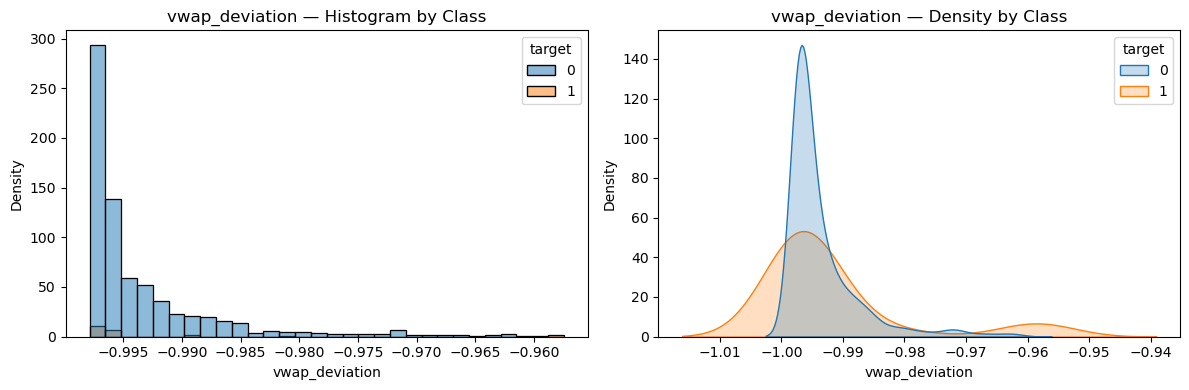


📊 Analyzing: z_score_vwap
Class 0 (no TP): mean=-1.5850, std=0.2269, count=922
Class 1 (TP):     mean=-1.4310, std=0.3097, count=29
T-statistic: -2.6553 | p-value: 0.0127
➡️ Moderate separation


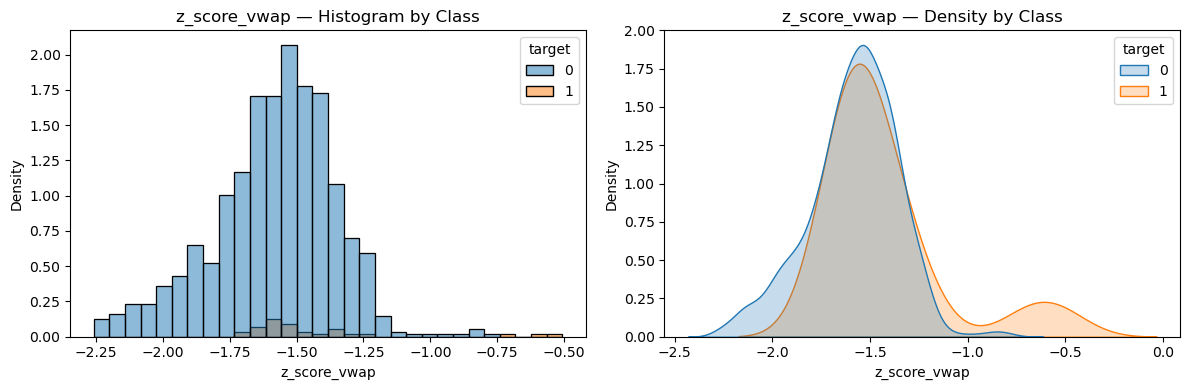


📊 Analyzing: rsi
Class 0 (no TP): mean=51.1370, std=12.4057, count=922
Class 1 (TP):     mean=56.7551, std=13.5574, count=29
T-statistic: -2.2028 | p-value: 0.0356
➡️ Small separation


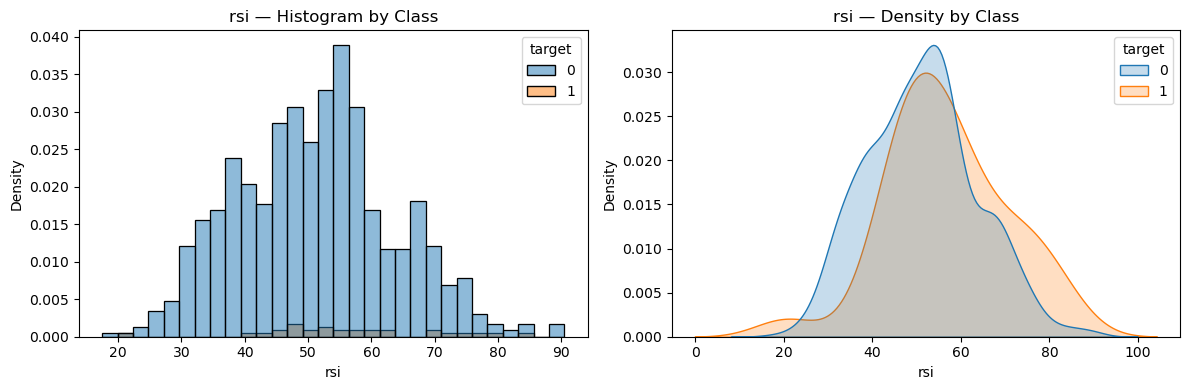


📊 Analyzing: rsi_slope
Class 0 (no TP): mean=-0.0606, std=4.8130, count=922
Class 1 (TP):     mean=0.8400, std=3.4214, count=29
T-statistic: -1.3753 | p-value: 0.1787
➡️ Small separation


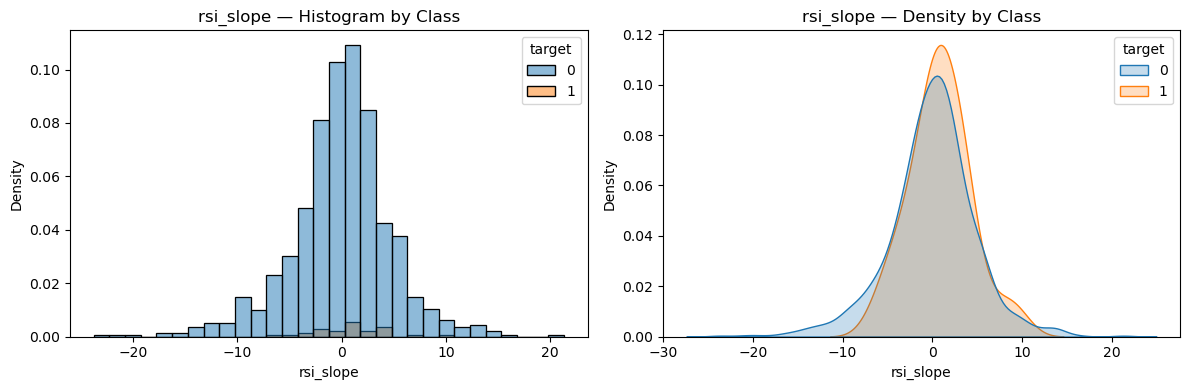


📊 Analyzing: roc
Class 0 (no TP): mean=0.0000, std=0.0025, count=922
Class 1 (TP):     mean=0.0009, std=0.0027, count=29
T-statistic: -1.6546 | p-value: 0.1086
➡️ Small separation


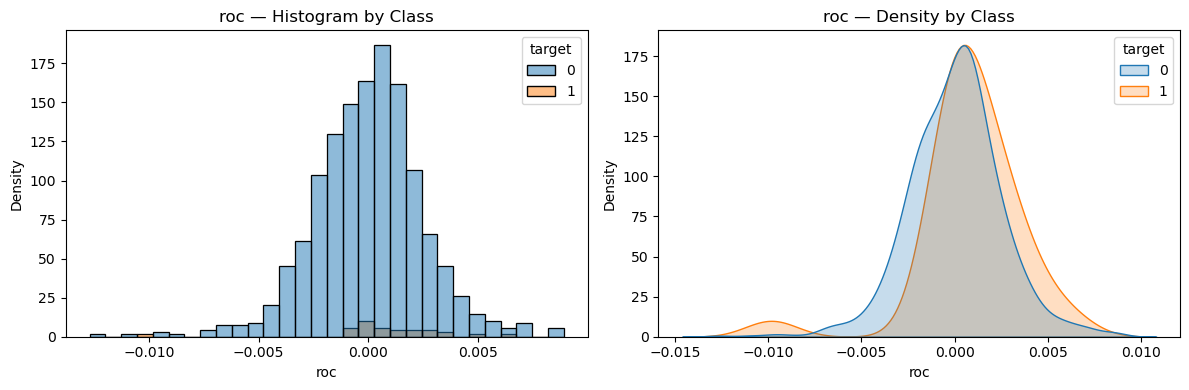


📊 Analyzing: momentum
Class 0 (no TP): mean=0.0001, std=0.0040, count=922
Class 1 (TP):     mean=0.0016, std=0.0038, count=29
T-statistic: -2.0646 | p-value: 0.0477
➡️ Small separation


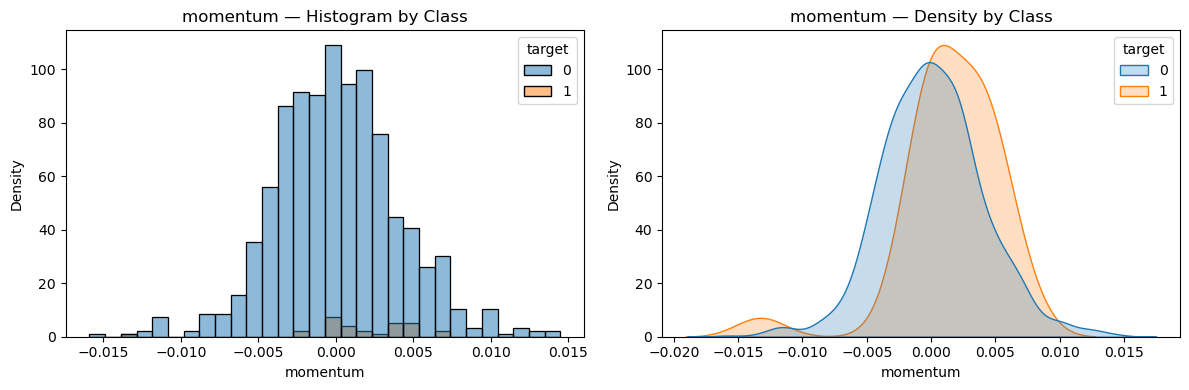


📊 Analyzing: atr
Class 0 (no TP): mean=0.0018, std=0.0005, count=922
Class 1 (TP):     mean=0.0016, std=0.0004, count=29
T-statistic: 3.3128 | p-value: 0.0024
➡️ Moderate separation


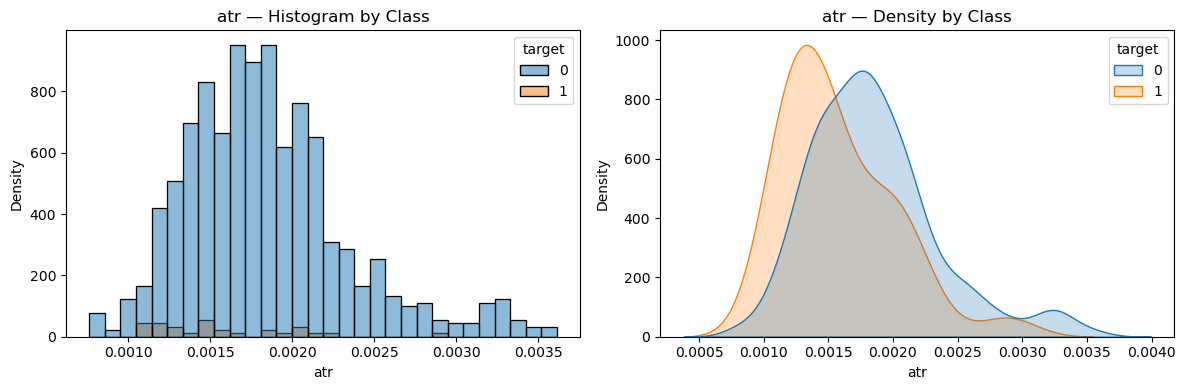


📊 Analyzing: volatility
Class 0 (no TP): mean=0.0011, std=0.0004, count=922
Class 1 (TP):     mean=0.0011, std=0.0003, count=29
T-statistic: 0.2018 | p-value: 0.8414
➡️ Very weak separation (Cohen's d < 0.2)


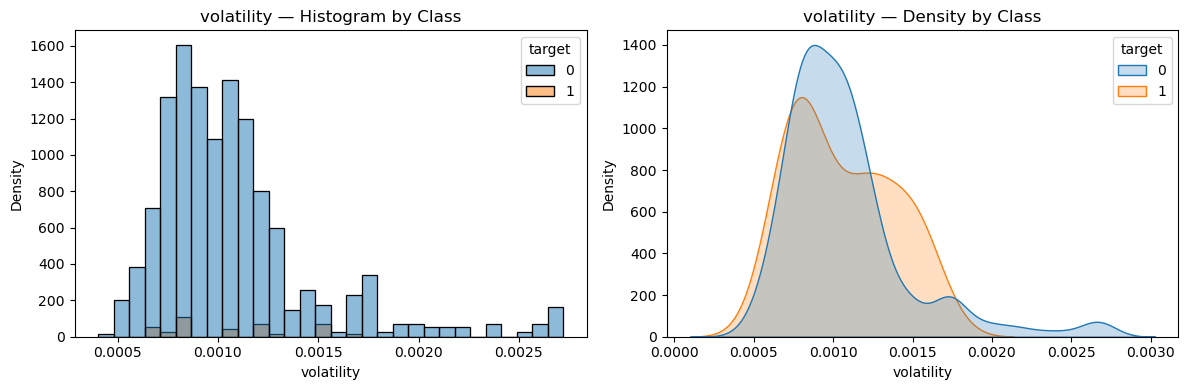


📊 Analyzing: candle_body
Class 0 (no TP): mean=-0.0000, std=0.0013, count=922
Class 1 (TP):     mean=0.0003, std=0.0011, count=29
T-statistic: -1.4030 | p-value: 0.1706
➡️ Small separation


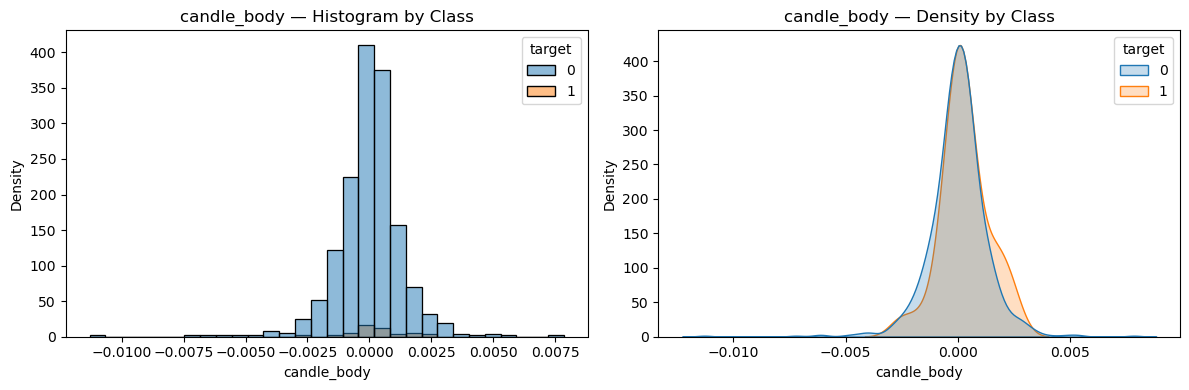


📊 Analyzing: wick_upper
Class 0 (no TP): mean=0.0009, std=0.0010, count=922
Class 1 (TP):     mean=0.0008, std=0.0007, count=29
T-statistic: 0.8922 | p-value: 0.3791
➡️ Very weak separation (Cohen's d < 0.2)


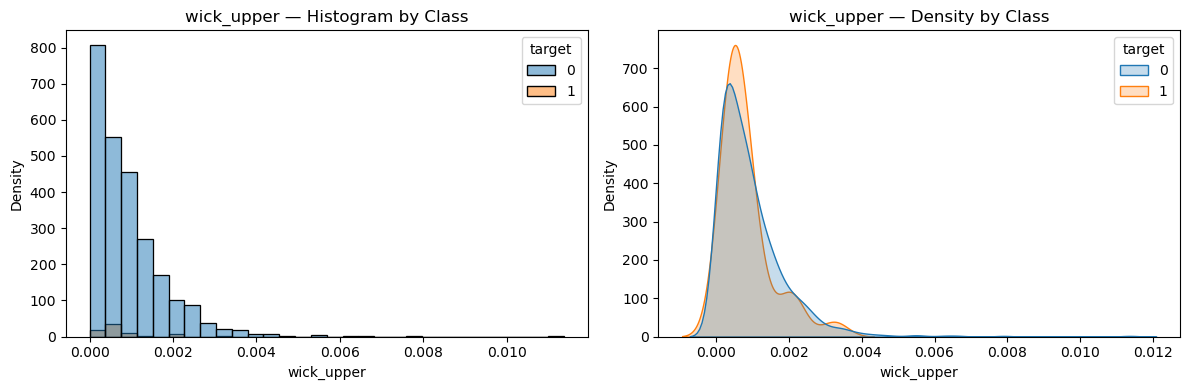


📊 Analyzing: wick_lower
Class 0 (no TP): mean=0.0009, std=0.0008, count=922
Class 1 (TP):     mean=0.0011, std=0.0009, count=29
T-statistic: -0.9813 | p-value: 0.3344
➡️ Very weak separation (Cohen's d < 0.2)


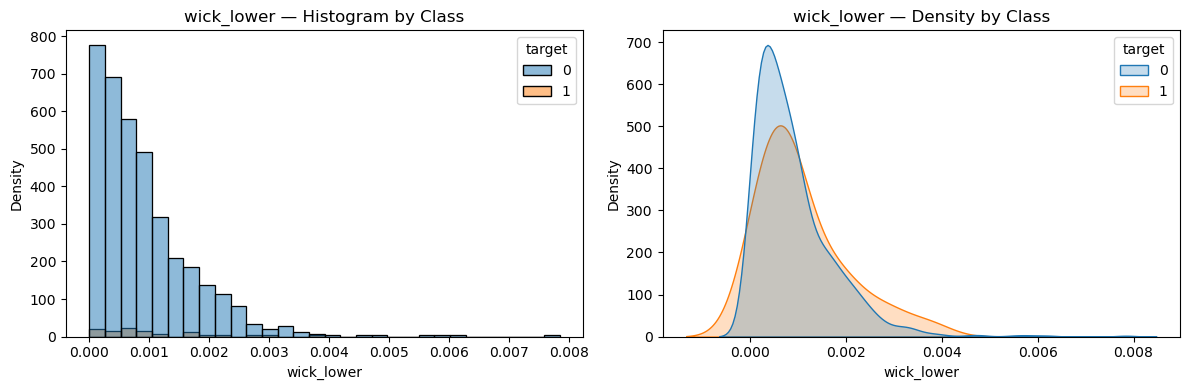


📊 Analyzing: volume_deviation
Class 0 (no TP): mean=0.0372, std=0.6754, count=922
Class 1 (TP):     mean=0.0554, std=0.3720, count=29
T-statistic: -0.2508 | p-value: 0.8035
➡️ Very weak separation (Cohen's d < 0.2)


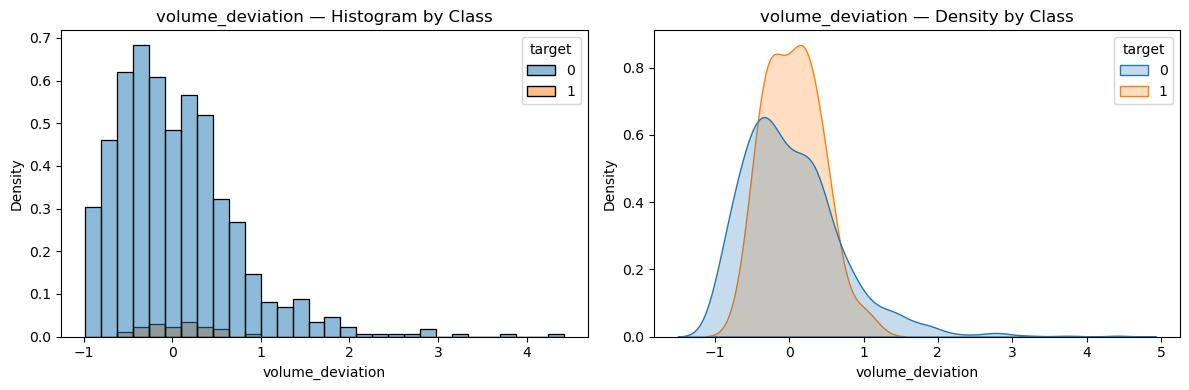


🧠 FINAL VERDICT:
✅ These features show meaningful separation: ['z_score_vwap', 'rsi', 'momentum', 'atr']
Model has a chance to learn.

📈 Label Distribution After Triple Barrier
target
0    0.969506
1    0.030494
Name: proportion, dtype: float64

📊 Summary of Feature Quality:
             feature  effect_size  significant
6                atr     0.576761         True
1       z_score_vwap     0.567212         True
2                rsi     0.432352         True
5           momentum     0.381082         True
4                roc     0.323682        False
8        candle_body     0.238719        False
3          rsi_slope     0.215674        False
0     vwap_deviation     0.197511        False
10        wick_lower     0.193367        False
9         wick_upper     0.143608        False
7         volatility     0.033779        False
11  volume_deviation     0.033375        False


In [11]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
from scipy.stats import ttest_ind
from collections import namedtuple
# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # RSI
    df['rsi'] = ta.rsi(df['close'], length=14)
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)

    # Momentum
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Candlestick
    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # Volume
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    return df.dropna()

# =============================
# 3. Triple Barrier Labeling
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, pt_sl=[0.005, 0.005], look_forward=5):
    """
    Apply triple barrier method using dynamic thresholds per event.
    Returns Series of {-1 (SL), 0 (neutral), +1 (TP)}
    """
    out = pd.Series(index=events_df.index)

    for idx, event_time in enumerate(events_df.index):
        try:
            start = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        end = min(start + look_forward + 1, len(close_series))
        future_prices = close_series.iloc[start:end]
        entry_price = future_prices.iloc[0]
        tp = entry_price * (1 + pt_sl[0])
        sl = entry_price * (1 - pt_sl[1])

        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= tp:
                out.loc[event_time] = 1
                break
            elif price <= sl:
                out.loc[event_time] = -1
                break
        else:
            out.loc[event_time] = 0  # No trigger within time window

    return out.map({1: 1, -1: 0, 0: 0})  # Only predict upward reversion for now

# =============================
# 4. Prepare Events & Labels
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=5, pt_sl=[0.005, 0.005]):
    df = df.copy()
    events = pd.DataFrame(index=df.index)
    events['t1'] = df.index.to_series().shift(-look_forward).values
    df['target'] = apply_triple_barrier(df['close'], events, pt_sl=pt_sl, look_forward=look_forward)
    df['target'] = df['target'].fillna(0).astype(int)  # Default to neutral
    return df

# =============================
# 5. Feature Separation Analysis
# =============================
def analyze_feature_for_objective(df, feature_col):
    if feature_col not in df.columns:
        print(f"⚠️ Feature '{feature_col}' not found. Skipping.")
        return

    group0 = df[df['target'] == 0][feature_col]
    group1 = df[df['target'] == 1][feature_col]

    if len(group0) < 5 or len(group1) < 5:
        print(f"⚠️ Not enough samples in one class for {feature_col}")
        return

    mean0, std0 = group0.mean(), group0.std()
    mean1, std1 = group1.mean(), group1.std()
    diff_mean = abs(mean1 - mean0)
    combined_std = np.sqrt((std0**2 + std1**2) / 2)
    effect_size = diff_mean / combined_std

    print(f"\n📊 Analyzing: {feature_col}")
    print(f"Class 0 (no TP): mean={mean0:.4f}, std={std0:.4f}, count={len(group0)}")
    print(f"Class 1 (TP):     mean={mean1:.4f}, std={std1:.4f}, count={len(group1)}")

    # T-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-statistic: {t_stat:.4f} | p-value: {p_val:.4f}")

    # Effect size
    if effect_size < 0.2:
        print("➡️ Very weak separation (Cohen's d < 0.2)")
    elif effect_size < 0.5:
        print("➡️ Small separation")
    elif effect_size < 0.8:
        print("➡️ Moderate separation")
    else:
        print("✅ Strong separation — this feature helps!")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature_col, hue='target', bins=30, stat="density")
    plt.title(f"{feature_col} — Histogram by Class")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature_col, hue='target', fill=True, common_norm=False)
    plt.title(f"{feature_col} — Density by Class")

    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_col,
        'effect_size': effect_size,
        'significant': (p_val < 0.05 and effect_size > 0.2)
    }

# =============================
# 6. Run All Analyses
# =============================
def run_full_analysis(df):
    features = [
        'vwap_deviation',
        'z_score_vwap',
        'rsi',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    results = []
    for feature in features:
        result = analyze_feature_for_objective(df, feature)
        results.append(result)

    result_df = pd.DataFrame(results)
    significant_features = result_df[result_df['significant']]['feature'].tolist()

    print("\n🧠 FINAL VERDICT:")
    if len(significant_features) >= 1:
        print(f"✅ These features show meaningful separation: {significant_features}")
        print("Model has a chance to learn.")
    else:
        print("❌ No feature shows clear separation. Need better labeling.")

    return result_df

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier Method...")
    df = prepare_labels_with_triple_barrier(df, look_forward=5, pt_sl=[0.005, 0.005])

    print("\n📊 Feature Analysis Based on Objective")
    result_df = run_full_analysis(df)

    print("\n📈 Label Distribution After Triple Barrier")
    print(df['target'].value_counts(normalize=True))

    print("\n📊 Summary of Feature Quality:")
    print(result_df.sort_values(by='effect_size', ascending=False))

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier + ATR

📈 Label Distribution After Triple Barrier
reversion_label
0    0.846154
1    0.153846
Name: proportion, dtype: float64

📊 Feature Analysis Based on Objective

📊 Analyzing: vwap_deviation
Class 0 (no TP): mean=-0.9929, std=0.0065, count=759
Class 1 (TP):     mean=-0.9943, std=0.0049, count=138
T-statistic: 2.9507 | p-value: 0.0035
➡️ Small separation


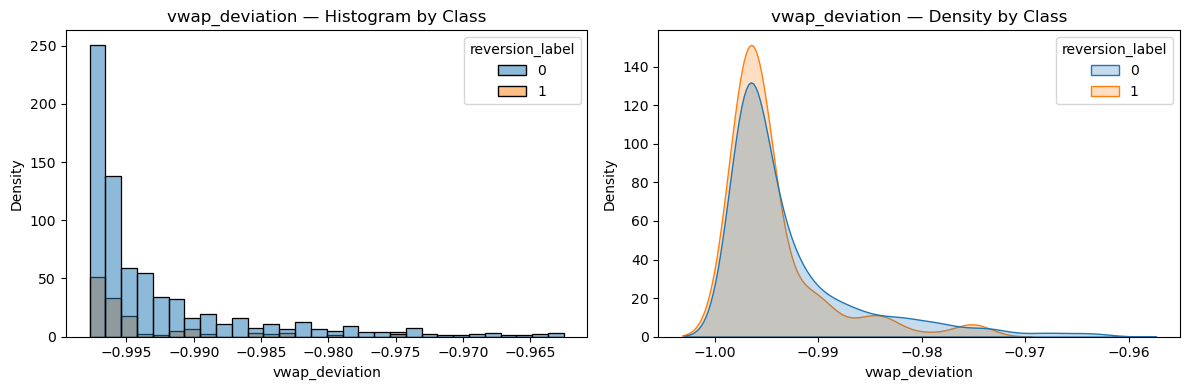


📊 Analyzing: z_score_vwap
Class 0 (no TP): mean=-1.5803, std=0.2453, count=759
Class 1 (TP):     mean=-1.5253, std=0.1568, count=138
T-statistic: -3.4258 | p-value: 0.0007
➡️ Small separation


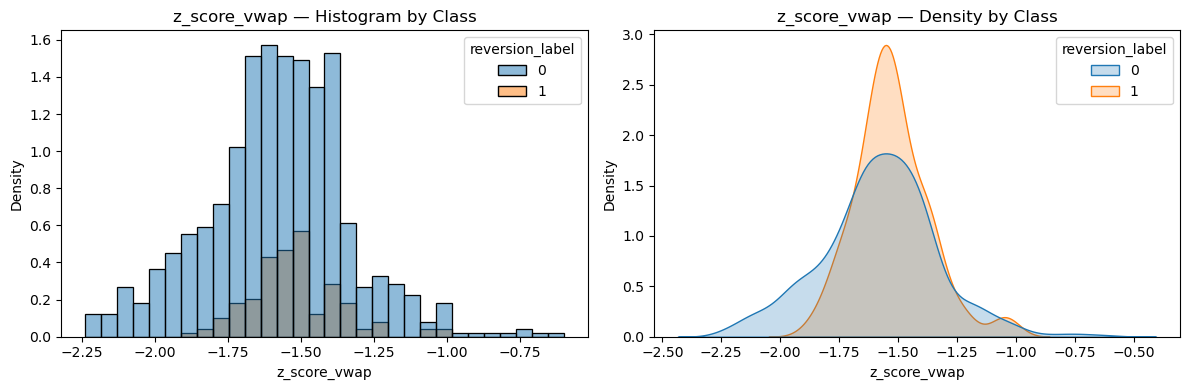


📊 Analyzing: rsi
Class 0 (no TP): mean=50.9532, std=12.0356, count=759
Class 1 (TP):     mean=51.3778, std=11.2012, count=138
T-statistic: -0.4049 | p-value: 0.6860
➡️ Very weak separation (Cohen's d < 0.2)


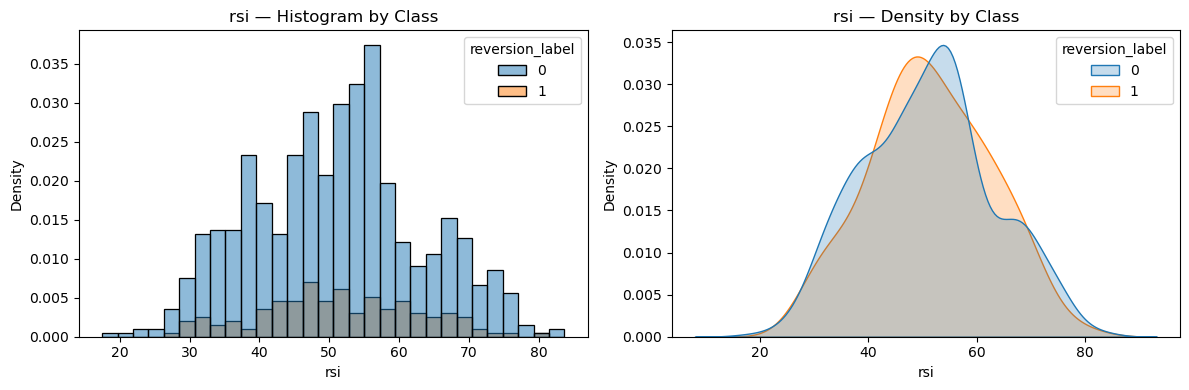


📊 Analyzing: rsi_slope
Class 0 (no TP): mean=-0.0247, std=4.7354, count=759
Class 1 (TP):     mean=0.1458, std=4.8427, count=138
T-statistic: -0.3817 | p-value: 0.7031
➡️ Very weak separation (Cohen's d < 0.2)


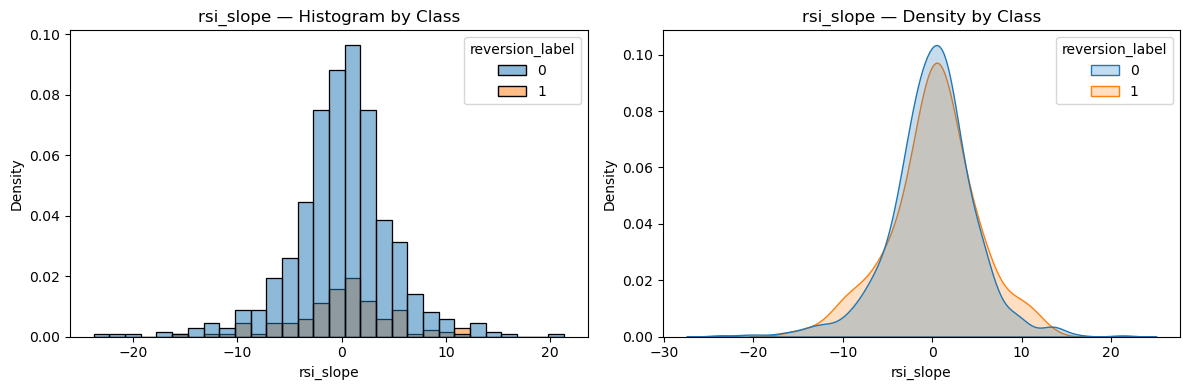


📊 Analyzing: roc
Class 0 (no TP): mean=0.0000, std=0.0025, count=759
Class 1 (TP):     mean=0.0003, std=0.0019, count=138
T-statistic: -1.5932 | p-value: 0.1125
➡️ Very weak separation (Cohen's d < 0.2)


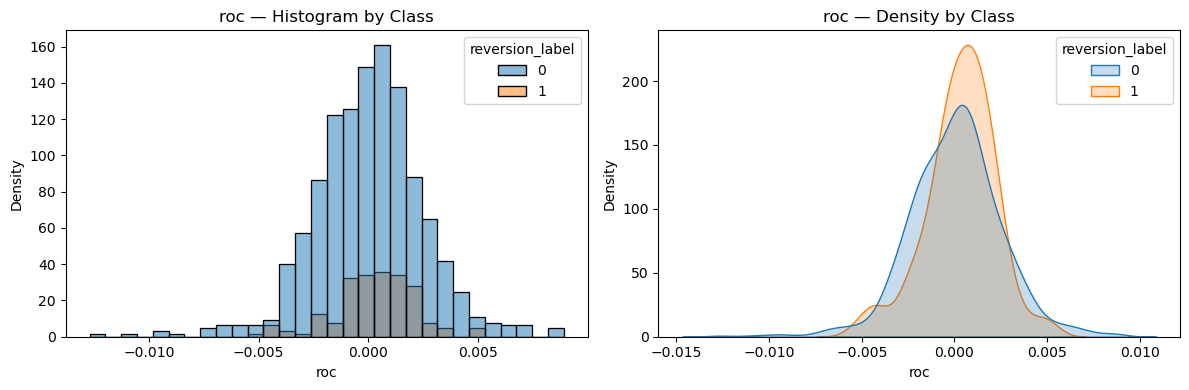


📊 Analyzing: momentum
Class 0 (no TP): mean=0.0000, std=0.0039, count=759
Class 1 (TP):     mean=0.0007, std=0.0028, count=138
T-statistic: -2.4944 | p-value: 0.0133
➡️ Small separation


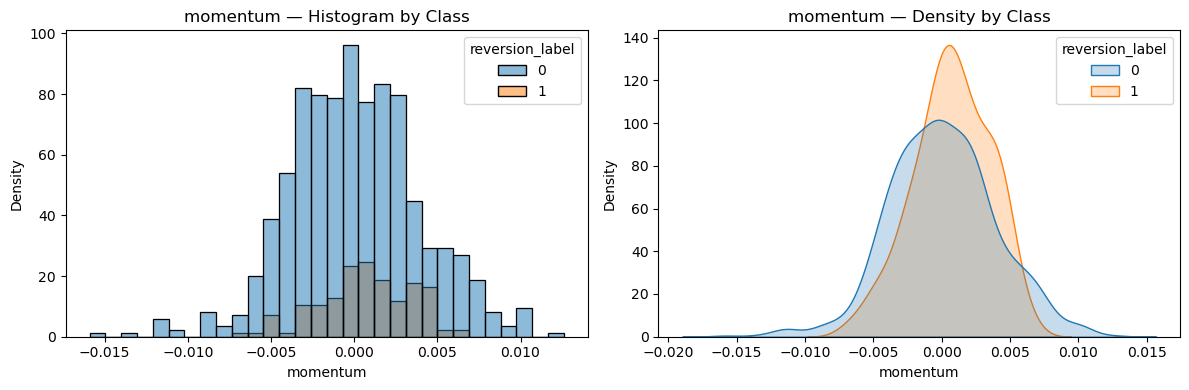


📊 Analyzing: atr
Class 0 (no TP): mean=0.0018, std=0.0005, count=759
Class 1 (TP):     mean=0.0015, std=0.0003, count=138
T-statistic: 9.4897 | p-value: 0.0000
➡️ Moderate separation


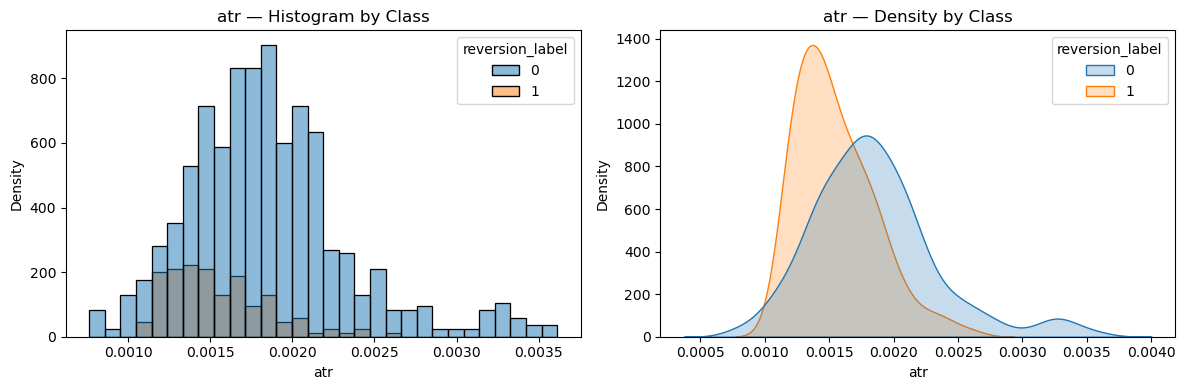


📊 Analyzing: volatility
Class 0 (no TP): mean=0.0011, std=0.0004, count=759
Class 1 (TP):     mean=0.0010, std=0.0003, count=138
T-statistic: 4.1294 | p-value: 0.0000
➡️ Small separation


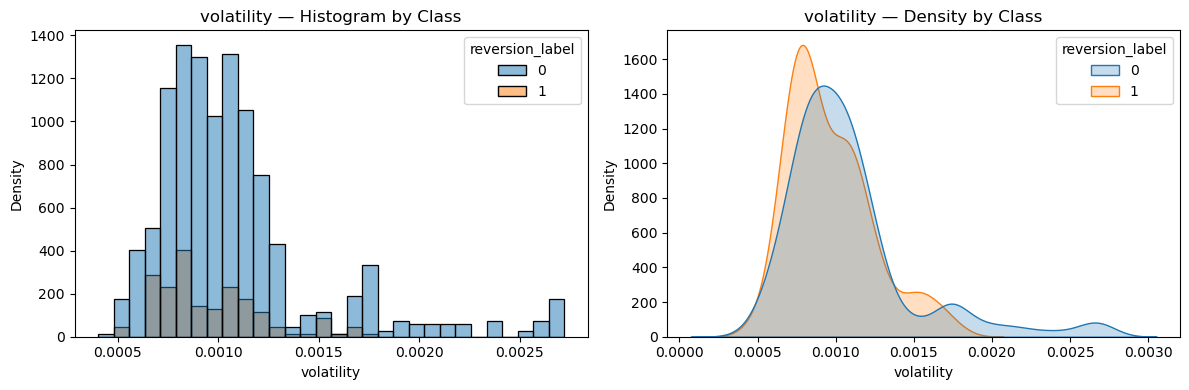


📊 Analyzing: candle_body
Class 0 (no TP): mean=0.0000, std=0.0013, count=759
Class 1 (TP):     mean=0.0001, std=0.0011, count=138
T-statistic: -0.5257 | p-value: 0.5997
➡️ Very weak separation (Cohen's d < 0.2)


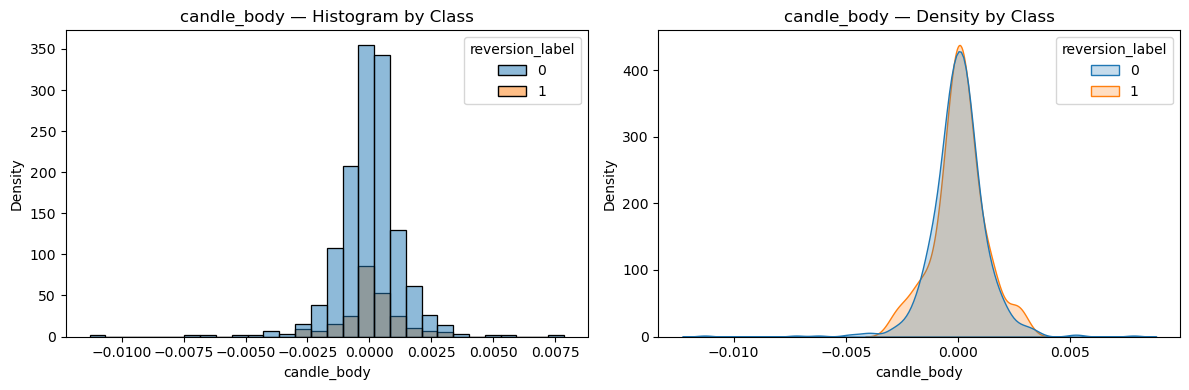


📊 Analyzing: wick_upper
Class 0 (no TP): mean=0.0009, std=0.0009, count=759
Class 1 (TP):     mean=0.0009, std=0.0008, count=138
T-statistic: 0.2386 | p-value: 0.8117
➡️ Very weak separation (Cohen's d < 0.2)


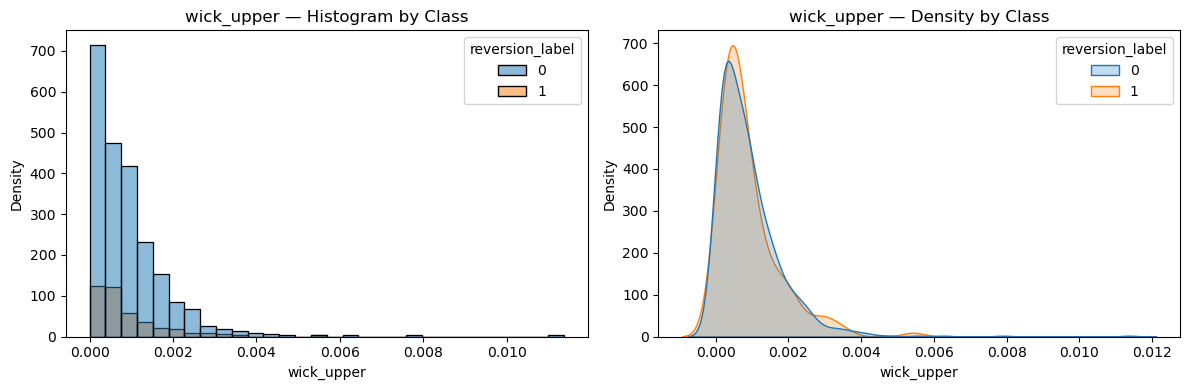


📊 Analyzing: wick_lower
Class 0 (no TP): mean=0.0009, std=0.0008, count=759
Class 1 (TP):     mean=0.0009, std=0.0008, count=138
T-statistic: 0.0835 | p-value: 0.9336
➡️ Very weak separation (Cohen's d < 0.2)


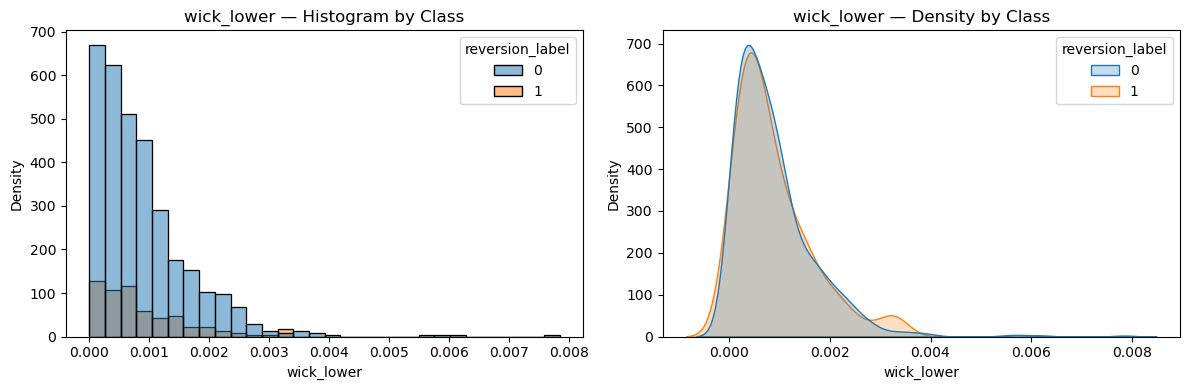


📊 Analyzing: volume_deviation
Class 0 (no TP): mean=0.0107, std=0.6625, count=759
Class 1 (TP):     mean=0.1504, std=0.7331, count=138
T-statistic: -2.0887 | p-value: 0.0381
➡️ Very weak separation (Cohen's d < 0.2)


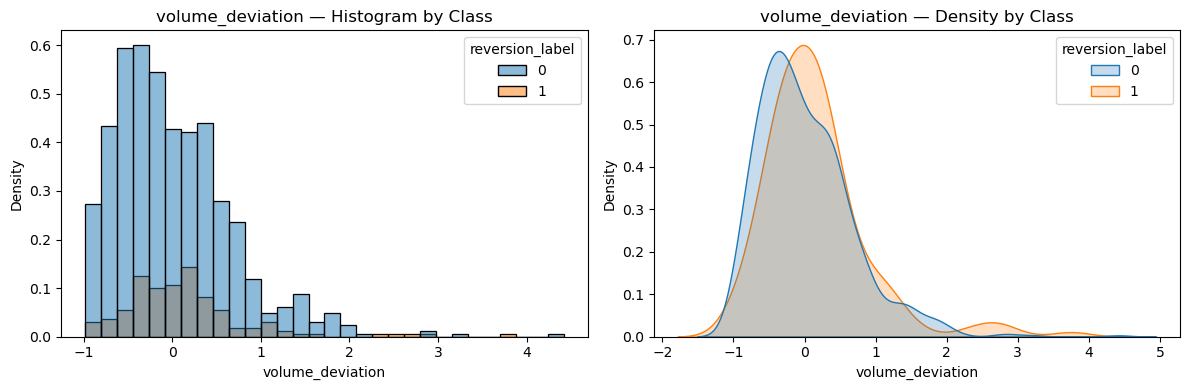


🧠 FINAL VERDICT:
✅ These features show meaningful separation: ['vwap_deviation', 'z_score_vwap', 'momentum', 'atr', 'volatility']
Model has a chance to learn from them.

📊 Summary of Feature Quality:
             feature  effect_size  significant
6                atr     0.729795         True
7         volatility     0.322745         True
1       z_score_vwap     0.266978         True
0     vwap_deviation     0.245820         True
5           momentum     0.203414         True
11  volume_deviation     0.199937        False
4                roc     0.132335        False
8        candle_body     0.046717        False
2                rsi     0.036524        False
3          rsi_slope     0.035597        False
9         wick_upper     0.021286        False
10        wick_lower     0.007549        False


In [13]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
from scipy.stats import ttest_ind
from collections import namedtuple

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # Momentum
    df['rsi'] = ta.rsi(df['close'], length=14)
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    macd = ta.macd(df['close'])
    df['macd_line'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = macd['MACDh_12_26_9']

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Candlestick
    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # Volume
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    df = df.dropna()
    return df

# =============================
# 3. Triple Barrier Labeling Function
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, df, look_forward=5, multiplier=1.5):
    out = pd.Series(index=events_df.index)

    for event_time in events_df.index:
        try:
            idx = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        if idx >= len(close_series) - look_forward:
            continue

        entry_price = close_series.iloc[idx]
        atr_value = df.loc[event_time, 'atr']

        upper_barrier = entry_price * (1 + atr_value * multiplier)
        lower_barrier = entry_price * (1 - atr_value * multiplier)

        future_prices = close_series.iloc[idx:idx + look_forward + 1]

        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= upper_barrier:
                out.loc[event_time] = 1
                break
            elif price <= lower_barrier:
                out.loc[event_time] = -1
                break
        else:
            out.loc[event_time] = 0  # No trigger within window

    return out.map({1:1, -1:0, 0:0})  # Only predict upward reversion

# =============================
# 4. Prepare Labels Using Triple Barrier
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=5, multiplier=1.5):
    df = engineer_features(df.copy())
    events = pd.DataFrame(index=df.index)
    df['reversion_label'] = apply_triple_barrier(df['close'], events, df, look_forward=look_forward, multiplier=multiplier)
    df = df.dropna(subset=['reversion_label'])
    df['reversion_label'] = df['reversion_label'].astype(int)
    return df

# =============================
# 5. Analyze Each Feature vs Label
# =============================
def analyze_feature_for_objective(df, feature_col):
    if feature_col not in df.columns:
        print(f"⚠️ Feature '{feature_col}' not found. Skipping.")
        return None

    group0 = df[df['reversion_label'] == 0][feature_col]
    group1 = df[df['reversion_label'] == 1][feature_col]

    if len(group0) < 5 or len(group1) < 5:
        print(f"⚠️ Not enough samples for {feature_col}")
        return None

    mean0, std0 = group0.mean(), group0.std()
    mean1, std1 = group1.mean(), group1.std()
    diff_mean = abs(mean1 - mean0)
    combined_std = np.sqrt((std0**2 + std1**2) / 2)
    effect_size = diff_mean / combined_std

    print(f"\n📊 Analyzing: {feature_col}")
    print(f"Class 0 (no TP): mean={mean0:.4f}, std={std0:.4f}, count={len(group0)}")
    print(f"Class 1 (TP):     mean={mean1:.4f}, std={std1:.4f}, count={len(group1)}")

    # T-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-statistic: {t_stat:.4f} | p-value: {p_val:.4f}")

    # Effect size
    if effect_size < 0.2:
        print("➡️ Very weak separation (Cohen's d < 0.2)")
    elif effect_size < 0.5:
        print("➡️ Small separation")
    elif effect_size < 0.8:
        print("➡️ Moderate separation")
    else:
        print("✅ Strong separation — this feature helps!")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df[[feature_col, 'reversion_label']], x=feature_col, hue='reversion_label', bins=30, stat="density")
    plt.title(f"{feature_col} — Histogram by Class")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature_col, hue='reversion_label', fill=True, common_norm=False)
    plt.title(f"{feature_col} — Density by Class")

    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_col,
        'effect_size': effect_size,
        'significant': p_val < 0.05 and effect_size > 0.2
    }

# =============================
# 6. Run All Analyses
# =============================
def run_full_analysis(df):
    features = [
        'vwap_deviation',
        'z_score_vwap',
        'rsi',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    results = []
    for feature in features:
        result = analyze_feature_for_objective(df, feature)
        if result is not None:
            results.append(result)

    result_df = pd.DataFrame(results)
    significant_features = result_df[result_df['significant']]['feature'].tolist()

    print("\n🧠 FINAL VERDICT:")
    if len(significant_features) >= 1:
        print(f"✅ These features show meaningful separation: {significant_features}")
        print("Model has a chance to learn from them.")
    else:
        print("❌ No feature shows clear separation. Need better labeling.")

    return result_df

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier + ATR")
    df = prepare_labels_with_triple_barrier(df, look_forward=5, multiplier=1.5)

    print("\n📈 Label Distribution After Triple Barrier")
    print(df['reversion_label'].value_counts(normalize=True))

    print("\n📊 Feature Analysis Based on Objective")
    result_df = run_full_analysis(df)

    print("\n📊 Summary of Feature Quality:")
    print(result_df.sort_values(by='effect_size', ascending=False))

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier + ATR

📈 Label Distribution After Triple Barrier
reversion_label
0    0.693946
1    0.306054
Name: proportion, dtype: float64

📊 Feature Analysis Based on Objective

📊 Analyzing: vwap_deviation
Class 0 (no TP): mean=-0.9926, std=0.0068, count=619
Class 1 (TP):     mean=-0.9944, std=0.0048, count=273
T-statistic: 4.5559 | p-value: 0.0000
➡️ Small separation


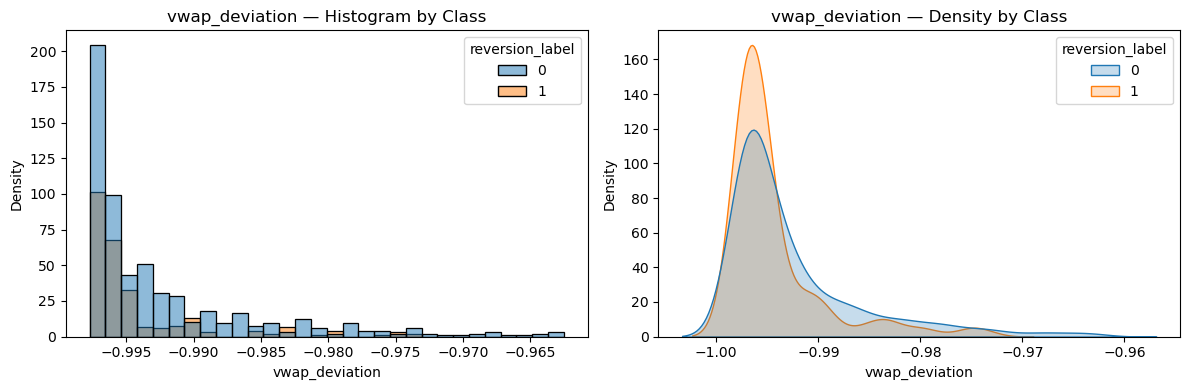


📊 Analyzing: z_score_vwap
Class 0 (no TP): mean=-1.5849, std=0.2540, count=619
Class 1 (TP):     mean=-1.5324, std=0.1660, count=273
T-statistic: -3.6634 | p-value: 0.0003
➡️ Small separation


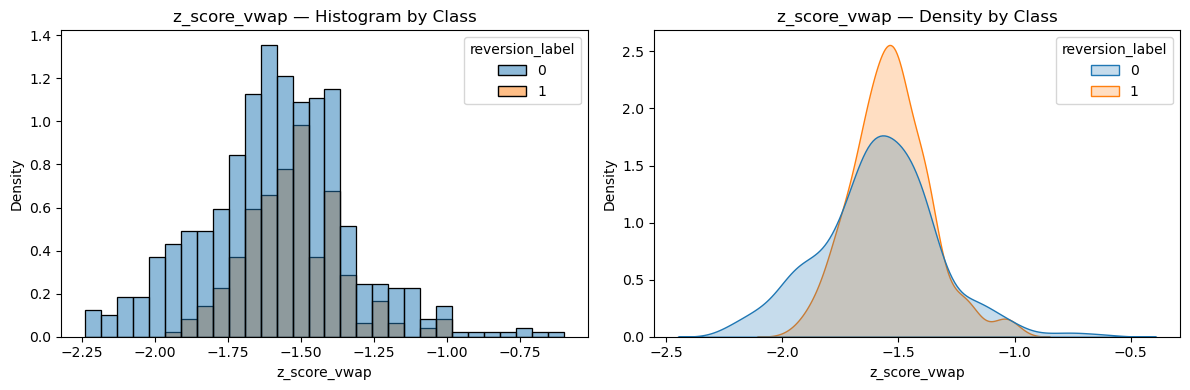


📊 Analyzing: rsi
Class 0 (no TP): mean=51.0892, std=11.9509, count=619
Class 1 (TP):     mean=50.9914, std=11.8899, count=273
T-statistic: 0.1130 | p-value: 0.9100
➡️ Very weak separation (Cohen's d < 0.2)


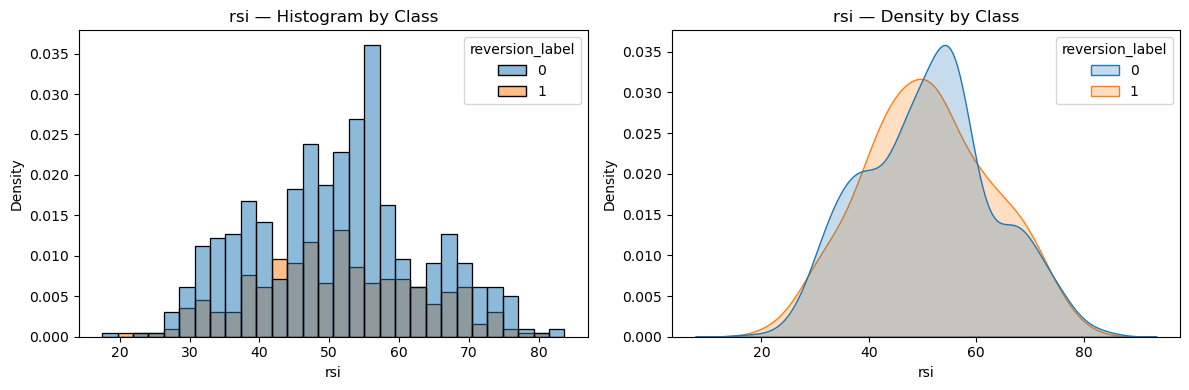


📊 Analyzing: rsi_slope
Class 0 (no TP): mean=-0.0949, std=4.6916, count=619
Class 1 (TP):     mean=0.2176, std=4.9068, count=273
T-statistic: -0.8882 | p-value: 0.3749
➡️ Very weak separation (Cohen's d < 0.2)


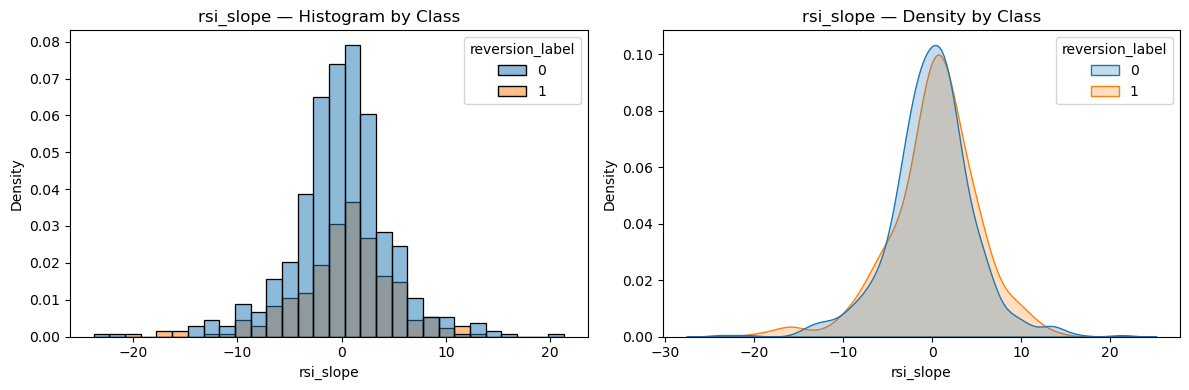


📊 Analyzing: roc
Class 0 (no TP): mean=0.0000, std=0.0026, count=619
Class 1 (TP):     mean=0.0003, std=0.0020, count=273
T-statistic: -1.7476 | p-value: 0.0810
➡️ Very weak separation (Cohen's d < 0.2)


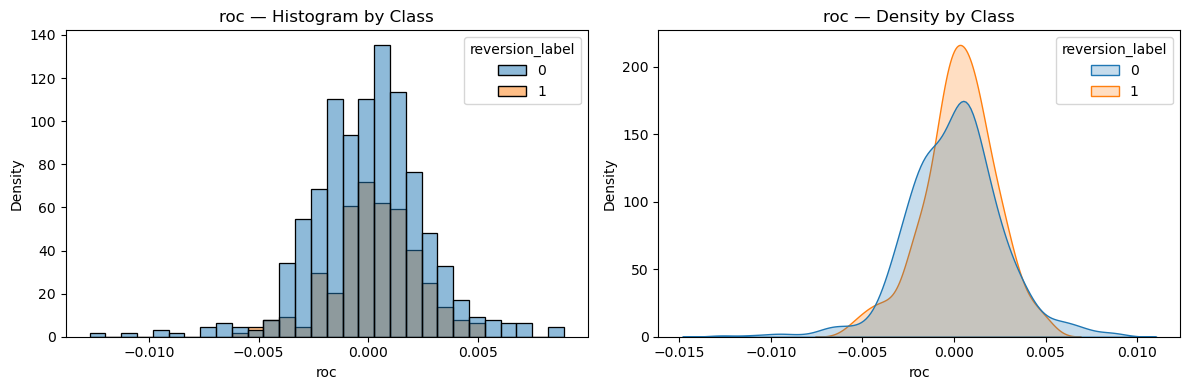


📊 Analyzing: momentum
Class 0 (no TP): mean=0.0001, std=0.0039, count=619
Class 1 (TP):     mean=0.0004, std=0.0031, count=273
T-statistic: -1.5571 | p-value: 0.1199
➡️ Very weak separation (Cohen's d < 0.2)


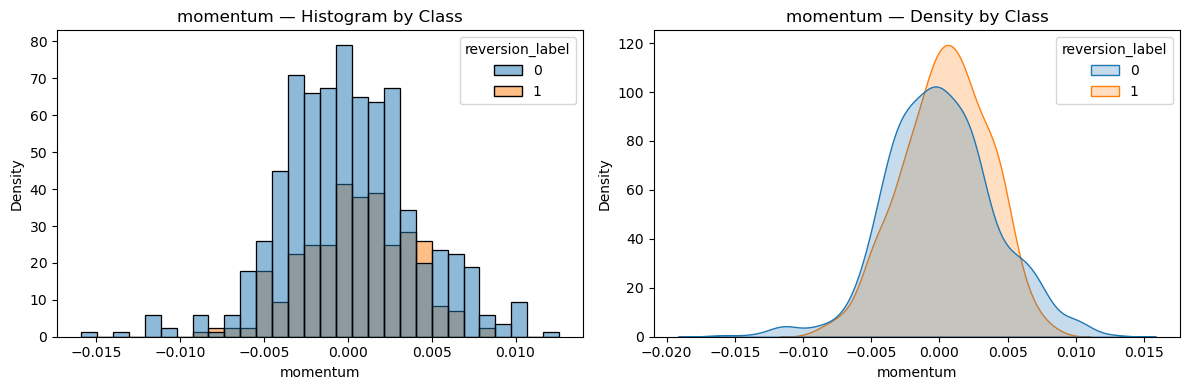


📊 Analyzing: atr
Class 0 (no TP): mean=0.0019, std=0.0005, count=619
Class 1 (TP):     mean=0.0016, std=0.0004, count=273
T-statistic: 8.1363 | p-value: 0.0000
➡️ Moderate separation


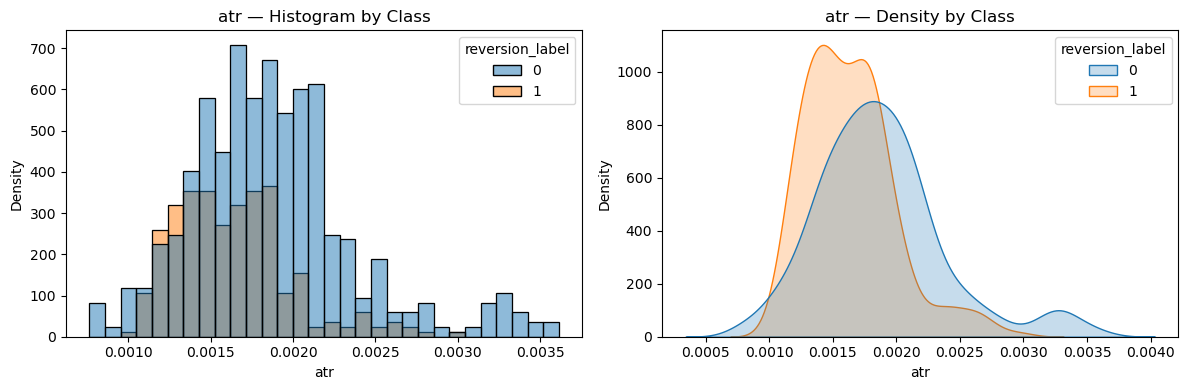


📊 Analyzing: volatility
Class 0 (no TP): mean=0.0011, std=0.0004, count=619
Class 1 (TP):     mean=0.0010, std=0.0003, count=273
T-statistic: 3.9913 | p-value: 0.0001
➡️ Small separation


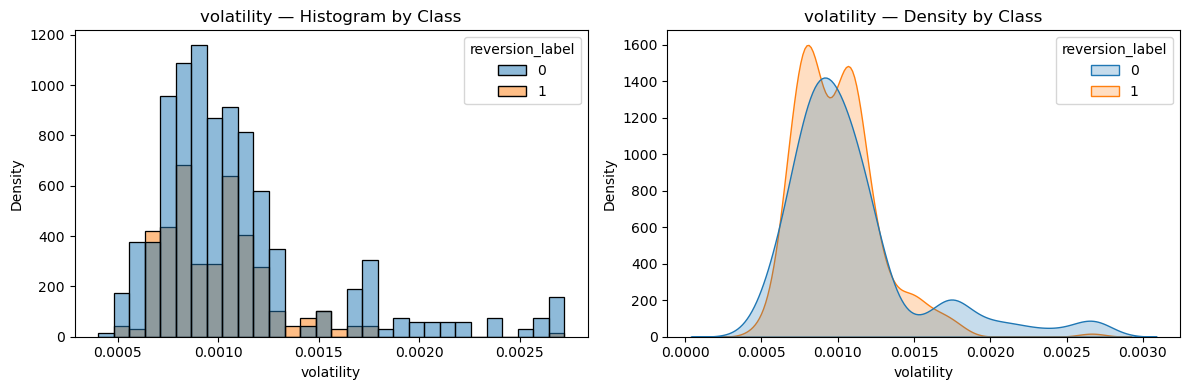


📊 Analyzing: candle_body
Class 0 (no TP): mean=-0.0000, std=0.0013, count=619
Class 1 (TP):     mean=0.0001, std=0.0012, count=273
T-statistic: -0.7342 | p-value: 0.4632
➡️ Very weak separation (Cohen's d < 0.2)


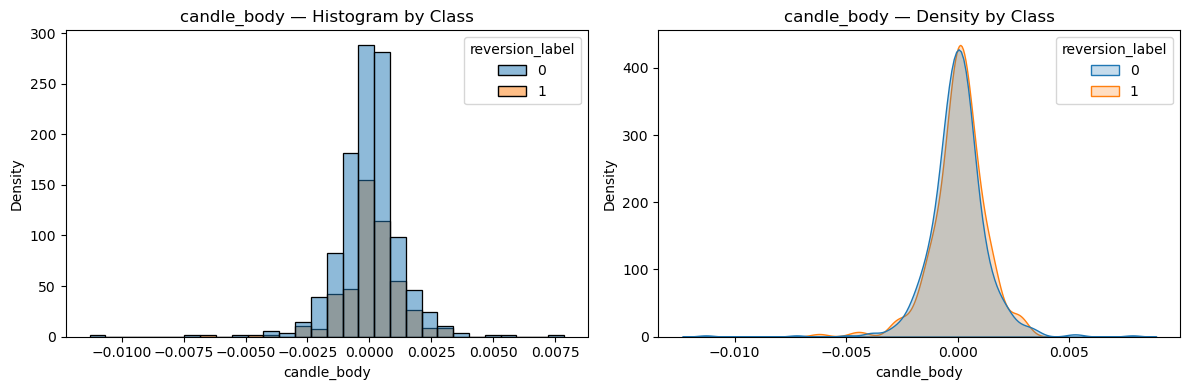


📊 Analyzing: wick_upper
Class 0 (no TP): mean=0.0009, std=0.0009, count=619
Class 1 (TP):     mean=0.0009, std=0.0009, count=273
T-statistic: 1.1688 | p-value: 0.2430
➡️ Very weak separation (Cohen's d < 0.2)


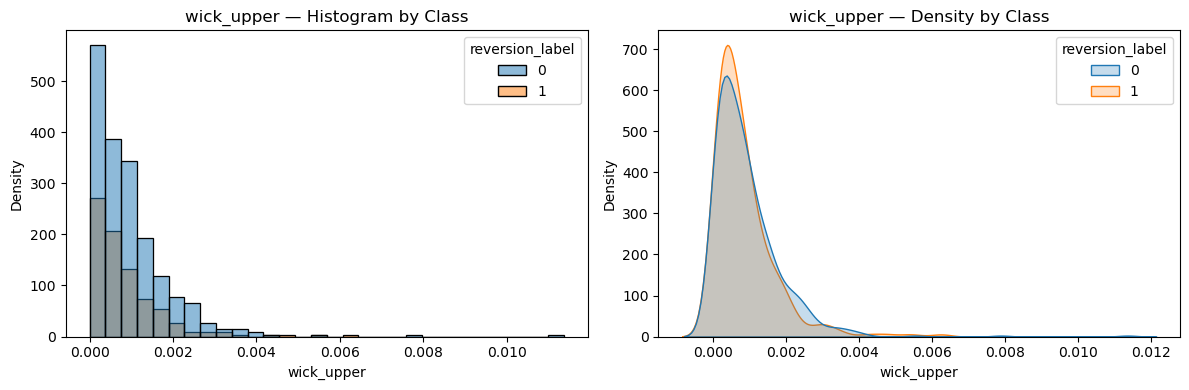


📊 Analyzing: wick_lower
Class 0 (no TP): mean=0.0009, std=0.0008, count=619
Class 1 (TP):     mean=0.0009, std=0.0007, count=273
T-statistic: 0.2798 | p-value: 0.7797
➡️ Very weak separation (Cohen's d < 0.2)


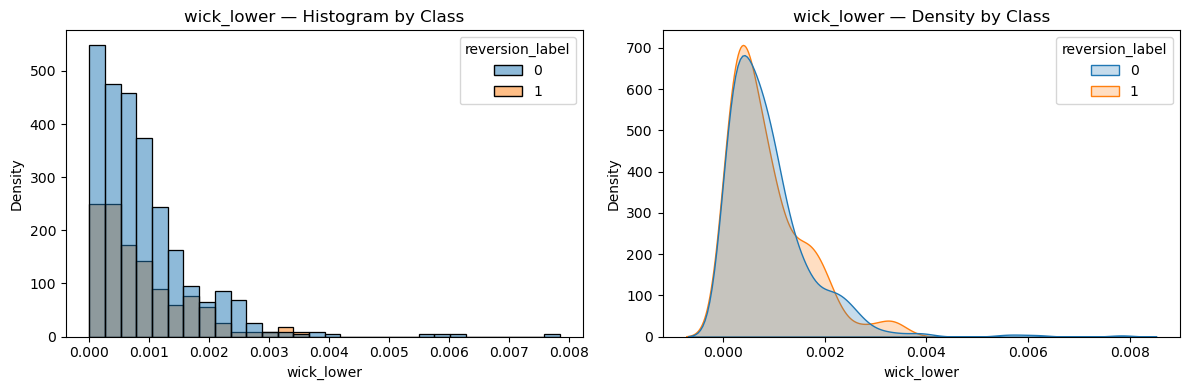


📊 Analyzing: volume_deviation
Class 0 (no TP): mean=0.0293, std=0.6756, count=619
Class 1 (TP):     mean=0.0361, std=0.6808, count=273
T-statistic: -0.1376 | p-value: 0.8906
➡️ Very weak separation (Cohen's d < 0.2)


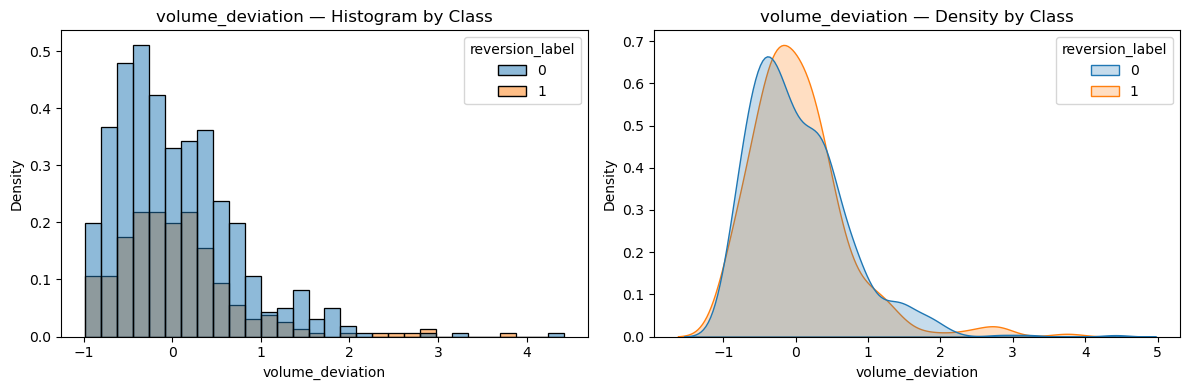


🧠 FINAL VERDICT:
✅ These features show meaningful separation: ['vwap_deviation', 'z_score_vwap', 'atr', 'volatility']
Model has a chance to learn from them.

📊 Summary of Feature Quality:
             feature  effect_size  significant
6                atr     0.548959         True
0     vwap_deviation     0.309285         True
7         volatility     0.262490         True
1       z_score_vwap     0.244568         True
4                roc     0.120404        False
5           momentum     0.108164        False
9         wick_upper     0.083255        False
3          rsi_slope     0.065090        False
8        candle_body     0.052358        False
10        wick_lower     0.019891        False
11  volume_deviation     0.010011        False
2                rsi     0.008205        False


In [15]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
from scipy.stats import ttest_ind
from collections import namedtuple

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # Momentum
    df['rsi'] = ta.rsi(df['close'], length=14)
    df['rsi_slope'] = df['rsi'] - df['rsi'].shift(1)
    df['roc'] = df['close'].pct_change(5)
    df['momentum'] = df['close'] - df['close'].shift(10)

    macd = ta.macd(df['close'])
    df['macd_line'] = macd['MACD_12_26_9']
    df['macd_signal'] = macd['MACDs_12_26_9']
    df['macd_hist'] = macd['MACDh_12_26_9']

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Candlestick
    df['candle_body'] = df['close'] - df['open']
    df['wick_upper'] = df['high'] - df['close']
    df['wick_lower'] = df['close'] - df['low']

    # Volume
    df['volume_ma'] = df['volume'].rolling(20).mean()
    df['volume_deviation'] = df['volume'] / df['volume_ma'] - 1

    df = df.dropna()
    return df

# =============================
# 3. Triple Barrier Labeling Function
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, df, look_forward=10, multiplier=1.5):
    out = pd.Series(index=events_df.index)

    for event_time in events_df.index:
        try:
            idx = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        if idx >= len(close_series) - look_forward:
            continue

        entry_price = close_series.iloc[idx]
        atr_value = df.loc[event_time, 'atr']

        upper_barrier = entry_price * (1 + atr_value * multiplier)
        lower_barrier = entry_price * (1 - atr_value * multiplier)

        future_prices = close_series.iloc[idx:idx + look_forward + 1]

        triggered = False
        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= upper_barrier:
                out.loc[event_time] = 1
                triggered = True
                break
            elif price <= lower_barrier:
                out.loc[event_time] = -1
                triggered = True
                break

        if not triggered:
            out.loc[event_time] = 0  # No trigger within window

    return out.map({1:1, -1:0, 0:0})  # Only predict upward reversion

# =============================
# 4. Prepare Labels Using Triple Barrier
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5):
    df = engineer_features(df.copy())
    events = pd.DataFrame(index=df.index)
    df['reversion_label'] = apply_triple_barrier(df['close'], events, df, look_forward=look_forward, multiplier=multiplier)
    df = df.dropna(subset=['reversion_label'])
    df['reversion_label'] = df['reversion_label'].astype(int)
    return df

# =============================
# 5. Analyze Each Feature vs Label
# =============================
def analyze_feature_for_objective(df, feature_col):
    if feature_col not in df.columns:
        print(f"⚠️ Feature '{feature_col}' not found. Skipping.")
        return None

    group0 = df[df['reversion_label'] == 0][feature_col]
    group1 = df[df['reversion_label'] == 1][feature_col]

    if len(group0) < 5 or len(group1) < 5:
        print(f"⚠️ Not enough samples for {feature_col}")
        return None

    mean0, std0 = group0.mean(), group0.std()
    mean1, std1 = group1.mean(), group1.std()
    diff_mean = abs(mean1 - mean0)
    combined_std = np.sqrt((std0**2 + std1**2) / 2)
    effect_size = diff_mean / combined_std

    print(f"\n📊 Analyzing: {feature_col}")
    print(f"Class 0 (no TP): mean={mean0:.4f}, std={std0:.4f}, count={len(group0)}")
    print(f"Class 1 (TP):     mean={mean1:.4f}, std={std1:.4f}, count={len(group1)}")

    # T-test
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    print(f"T-statistic: {t_stat:.4f} | p-value: {p_val:.4f}")

    # Effect size
    if effect_size < 0.2:
        print("➡️ Very weak separation (Cohen's d < 0.2)")
    elif effect_size < 0.5:
        print("➡️ Small separation")
    elif effect_size < 0.8:
        print("➡️ Moderate separation")
    else:
        print("✅ Strong separation — this feature helps!")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df[[feature_col, 'reversion_label']], x=feature_col, hue='reversion_label', bins=30, stat="density")
    plt.title(f"{feature_col} — Histogram by Class")

    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature_col, hue='reversion_label', fill=True, common_norm=False)
    plt.title(f"{feature_col} — Density by Class")

    plt.tight_layout()
    plt.show()

    return {
        'feature': feature_col,
        'effect_size': effect_size,
        'significant': p_val < 0.05 and effect_size > 0.2
    }

# =============================
# 6. Run All Analyses
# =============================
def run_full_analysis(df):
    features = [
        'vwap_deviation',
        'z_score_vwap',
        'rsi',
        'rsi_slope',
        'roc',
        'momentum',
        'atr',
        'volatility',
        'candle_body',
        'wick_upper',
        'wick_lower',
        'volume_deviation'
    ]

    results = []
    for feature in features:
        result = analyze_feature_for_objective(df, feature)
        if result is not None:
            results.append(result)

    result_df = pd.DataFrame(results)
    significant_features = result_df[result_df['significant']]['feature'].tolist()

    print("\n🧠 FINAL VERDICT:")
    if len(significant_features) >= 1:
        print(f"✅ These features show meaningful separation: {significant_features}")
        print("Model has a chance to learn from them.")
    else:
        print("❌ No feature shows clear separation. Need better labeling.")

    return result_df

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier + ATR")
    df = prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5)

    print("\n📈 Label Distribution After Triple Barrier")
    print(df['reversion_label'].value_counts(normalize=True))

    print("\n📊 Feature Analysis Based on Objective")
    result_df = run_full_analysis(df)

    print("\n📊 Summary of Feature Quality:")
    print(result_df.sort_values(by='effect_size', ascending=False))

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier + ATR

🧬 Feature Correlation Analysis

📊 Feature Correlation Matrix:
                vwap_deviation  z_score_vwap       atr  volatility
vwap_deviation        1.000000      0.549742  0.488444    0.330155
z_score_vwap          0.549742      1.000000 -0.121004    0.014818
atr                   0.488444     -0.121004  1.000000    0.690976
volatility            0.330155      0.014818  0.690976    1.000000


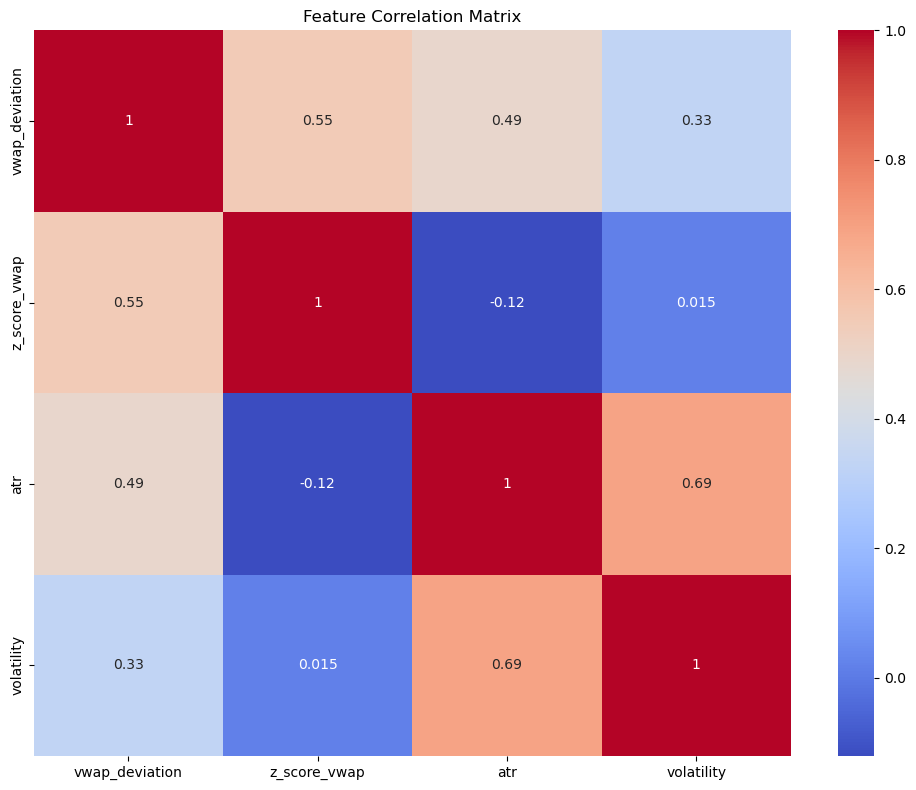


📈 Pairwise Distribution Plots:


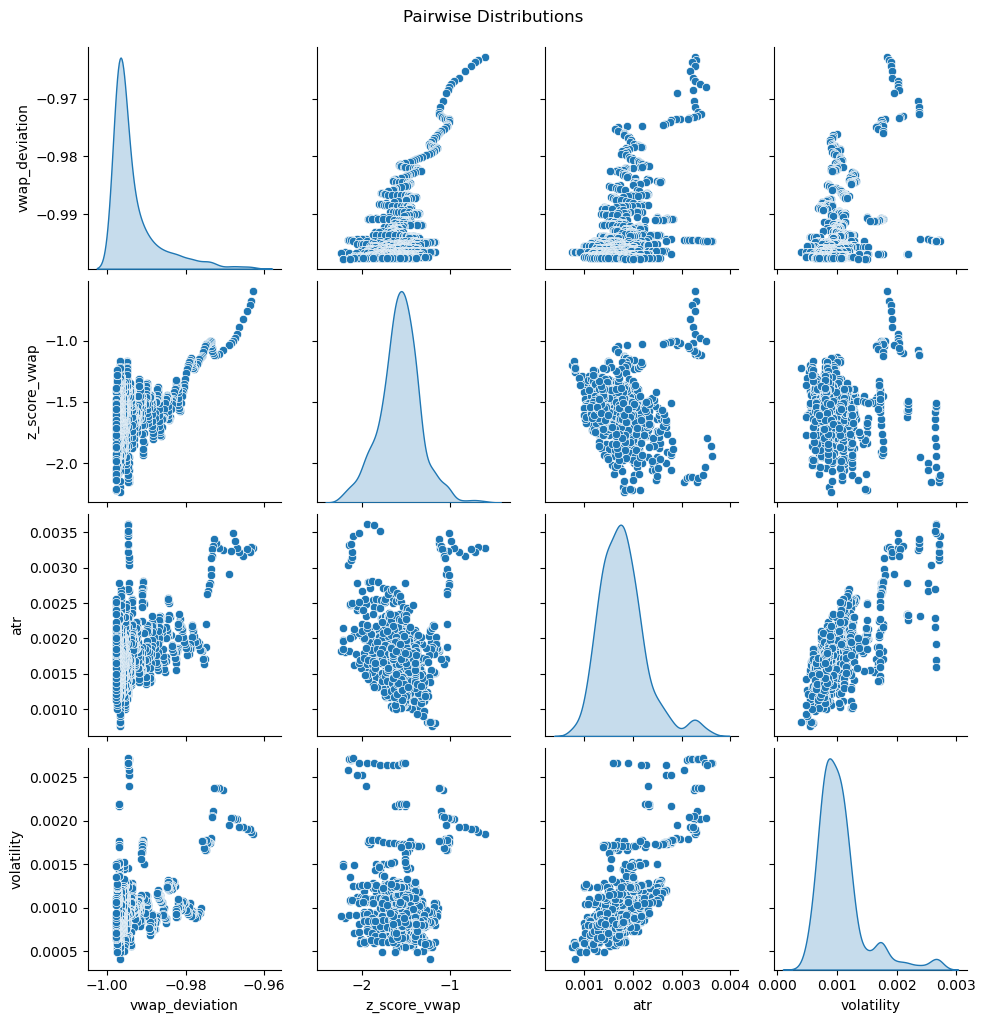


🧮 Variance Inflation Factors (Multicollinearity):
          feature       VIF
1  vwap_deviation  2.658461
2    z_score_vwap  2.093400
3             atr  3.125352
4      volatility  1.997374


In [17]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
from collections import namedtuple
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Drop missing values
    df = df.dropna()
    return df

# =============================
# 3. Triple Barrier Labeling Function
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, df, look_forward=10, multiplier=1.5):
    out = pd.Series(index=events_df.index)

    for event_time in events_df.index:
        try:
            idx = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        if idx >= len(close_series) - look_forward:
            continue

        entry_price = close_series.iloc[idx]
        atr_value = df.loc[event_time, 'atr']

        upper_barrier = entry_price * (1 + atr_value * multiplier)
        lower_barrier = entry_price * (1 - atr_value * multiplier)

        future_prices = close_series.iloc[idx:idx + look_forward + 1]

        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= upper_barrier:
                out.loc[event_time] = 1
                break
            elif price <= lower_barrier:
                out.loc[event_time] = -1
                break
        else:
            out.loc[event_time] = 0  # No trigger within window

    return out.map({1:1, -1:0, 0:0})  # Only predict upward reversion

# =============================
# 4. Prepare Labels Using Triple Barrier
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5):
    df = engineer_features(df.copy())
    events = pd.DataFrame(index=df.index)
    df['reversion_label'] = apply_triple_barrier(df['close'], events, df, look_forward=look_forward, multiplier=multiplier)
    df = df.dropna(subset=['reversion_label'])
    df['reversion_label'] = df['reversion_label'].astype(int)
    return df

# =============================
# 5. Run Correlation Analysis
# =============================
def analyze_feature_correlations(df, features):
    print("\n📊 Feature Correlation Matrix:")
    corr_matrix = df[features].corr()
    print(corr_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # Pairplot
    print("\n📈 Pairwise Distribution Plots:")
    sns.pairplot(data=df[features], diag_kind='kde')
    plt.suptitle("Pairwise Distributions", y=1.02)
    plt.show()

    # Variance Inflation Factor (VIF) - optional but powerful
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    df_with_const = add_constant(df[features])
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

    print("\n🧮 Variance Inflation Factors (Multicollinearity):")
    print(vif_data[vif_data['feature'] != 'const'])

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier + ATR")
    df = prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5)

    significant_features = ['vwap_deviation', 'z_score_vwap', 'atr', 'volatility']

    print("\n🧬 Feature Correlation Analysis")
    analyze_feature_correlations(df, significant_features)

📥 Fetching data...

🛠 Feature Engineering...

🛡 Labeling with Triple Barrier + ATR

📈 Label Distribution After Triple Barrier
target
0    0.693946
1    0.306054
Name: proportion, dtype: float64

🧠 Train Model Safely (Walk-Forward Validation)
=== Walk-Forward Evaluation ===


Fold 0 Evaluation:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       113
           1       0.08      0.03      0.04        35

    accuracy                           0.70       148
   macro avg       0.42      0.47      0.43       148
weighted avg       0.59      0.70      0.64       148

ROC AUC: 0.5818


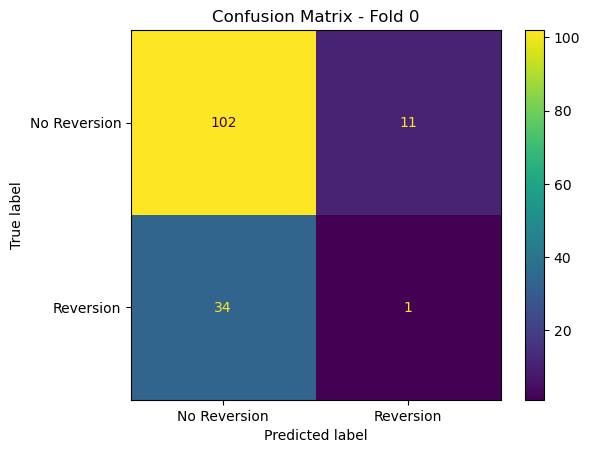


Fold 1 Evaluation:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        96
           1       0.49      0.37      0.42        52

    accuracy                           0.64       148
   macro avg       0.59      0.58      0.58       148
weighted avg       0.62      0.64      0.63       148

ROC AUC: 0.6810


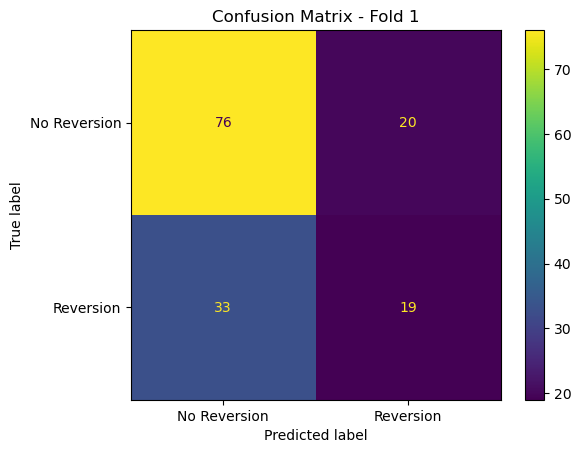


Fold 2 Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.61      0.60        93
           1       0.28      0.25      0.27        55

    accuracy                           0.48       148
   macro avg       0.43      0.43      0.43       148
weighted avg       0.47      0.48      0.47       148

ROC AUC: 0.4150


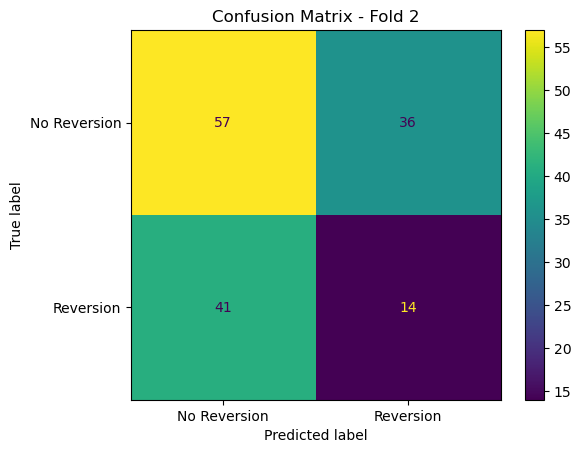


Fold 3 Evaluation:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       100
           1       0.24      0.15      0.18        48

    accuracy                           0.57       148
   macro avg       0.45      0.46      0.45       148
weighted avg       0.52      0.57      0.54       148

ROC AUC: 0.4718


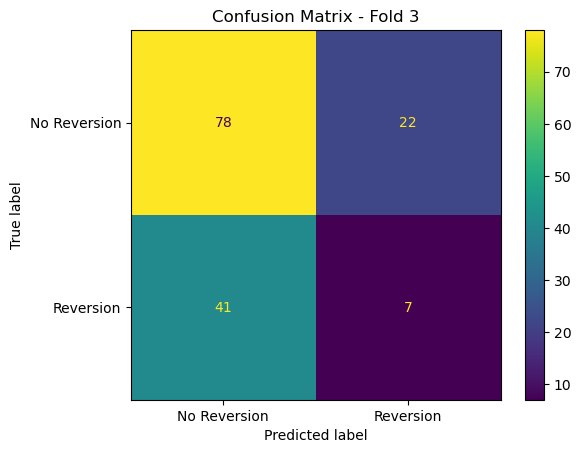


Fold 4 Evaluation:
              precision    recall  f1-score   support

           0       0.60      0.77      0.68        92
           1       0.30      0.16      0.21        56

    accuracy                           0.54       148
   macro avg       0.45      0.47      0.44       148
weighted avg       0.49      0.54      0.50       148

ROC AUC: 0.6088


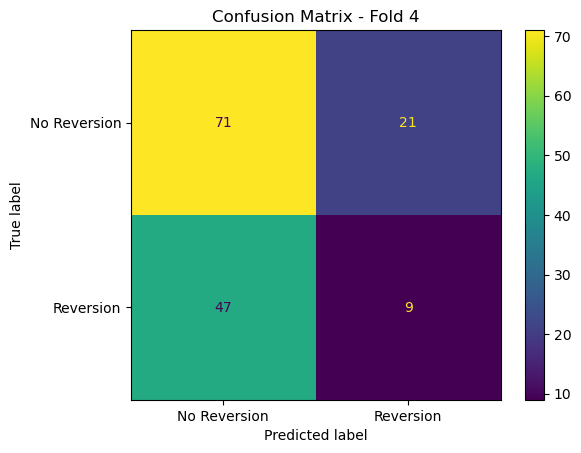


📊 Average Performance Across Folds:
precision    0.278378
recall       0.191010
f1           0.223585
dtype: float64

📊 Feature Importance


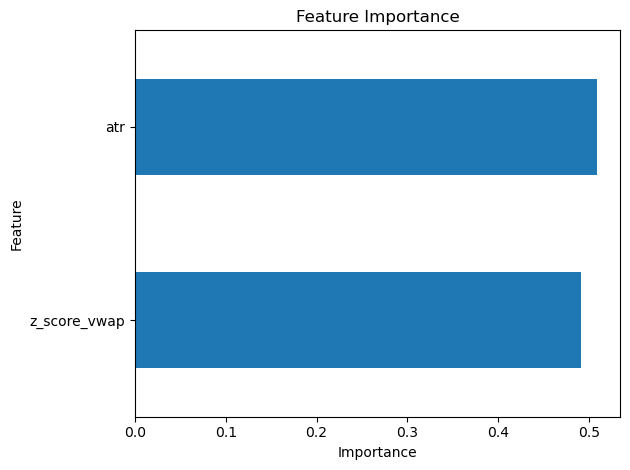


✅ ML pipeline complete.


In [19]:
import oandapyV20
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from collections import namedtuple
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# =============================
# 1. Fetch Historical Data
# =============================
def fetch_data(instrument="EUR_USD", granularity="H1", count=1000):
    client = API(access_token="32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693", environment="practice")
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    client.request(r)

    data = [{
        'datetime': candle['time'],
        'open': float(candle['mid']['o']),
        'high': float(candle['mid']['h']),
        'low': float(candle['mid']['l']),
        'close': float(candle['mid']['c']),
        'volume': candle['volume']
    } for candle in r.response['candles']]

    df = pd.DataFrame(data)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    return df[['open', 'high', 'low', 'close', 'volume']].copy()

# =============================
# 2. Feature Engineering
# =============================
def engineer_features(df):
    df = df.copy()

    # VWAP & Deviation
    df['vwap'] = (df['close'].cumsum() * df['volume']).cumsum() / df['volume'].cumsum()
    df['vwap_deviation'] = (df['close'] - df['vwap']) / df['vwap']
    df['z_score_vwap'] = ((df['vwap_deviation'] - df['vwap_deviation'].rolling(50).mean()) /
                          df['vwap_deviation'].rolling(50).std())

    # Volatility
    df['tr'] = df['high'] - df['low']
    df['atr'] = df['tr'].rolling(14).mean()
    df['volatility'] = df['close'].pct_change().rolling(20).std()

    # Drop missing values
    df = df.dropna()
    return df

# =============================
# 3. Triple Barrier Labeling Function
# =============================
Label = namedtuple('Label', ['label', 'timestamp'])

def apply_triple_barrier(close_series, events_df, df, look_forward=10, multiplier=1.5):
    out = pd.Series(index=events_df.index)

    for event_time in events_df.index:
        try:
            idx = close_series.index.get_loc(event_time)
        except KeyError:
            continue

        if idx >= len(close_series) - look_forward:
            continue

        entry_price = close_series.iloc[idx]
        atr_value = df.loc[event_time, 'atr']

        upper_barrier = entry_price * (1 + atr_value * multiplier)
        lower_barrier = entry_price * (1 - atr_value * multiplier)

        future_prices = close_series.iloc[idx:idx + look_forward + 1]

        for i in range(1, len(future_prices)):
            price = future_prices.iloc[i]
            if price >= upper_barrier:
                out.loc[event_time] = 1
                break
            elif price <= lower_barrier:
                out.loc[event_time] = -1
                break
        else:
            out.loc[event_time] = 0  # No trigger within window

    return out.map({1:1, -1:0, 0:0})  # Only predict upward reversion

# =============================
# 4. Prepare Labels Using Triple Barrier
# =============================
def prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5):
    df = engineer_features(df.copy())
    events = pd.DataFrame(index=df.index)
    df['target'] = apply_triple_barrier(df['close'], events, df, look_forward=look_forward, multiplier=multiplier)
    df = df.dropna(subset=['target'])
    df['target'] = df['target'].astype(int)
    return df

# =============================
# 5. Train Model Safely (Walk-Forward Validation)
# =============================
def train_model_walk_forward(X, y):
    from sklearn.metrics import precision_score, recall_score, f1_score

    tscv = TimeSeriesSplit(n_splits=5)
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    results = []

    print("=== Walk-Forward Evaluation ===\n")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if len(np.unique(y_train)) < 2:
            print(f"Skipping fold {fold} due to only one class in y_train")
            continue

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        pred_probs = model.predict_proba(X_test)[:, 1]

        print(f"\nFold {fold} Evaluation:")
        print(classification_report(y_test, preds, zero_division=0))

        if len(np.unique(y_test)) == 1:
            print("ROC AUC: Not defined (only one class in y_test)")
        else:
            print(f"ROC AUC: {roc_auc_score(y_test, pred_probs):.4f}")

        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Reversion', 'Reversion'])
        disp.plot()
        plt.title(f"Confusion Matrix - Fold {fold}")
        plt.show()

        results.append({
            'precision': precision_score(y_test, preds, pos_label=1),
            'recall': recall_score(y_test, preds, pos_label=1),
            'f1': f1_score(y_test, preds, pos_label=1)
        })

    result_df = pd.DataFrame(results)
    print("\n📊 Average Performance Across Folds:")
    print(result_df.mean())

    return model, result_df

# =============================
# 6. Plot Feature Importance
# =============================
def plot_feature_importance(model, X):
    fi = pd.Series(model.feature_importances_, index=X.columns)
    fi.sort_values().plot(kind='barh', title='Feature Importance')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# =============================
# Main Pipeline
# =============================
if __name__ == '__main__':
    print("📥 Fetching data...")
    df = fetch_data(instrument="EUR_USD", granularity="H1", count=1000)

    print("\n🛠 Feature Engineering...")
    df = engineer_features(df)

    print("\n🛡 Labeling with Triple Barrier + ATR")
    df = prepare_labels_with_triple_barrier(df, look_forward=10, multiplier=1.5)

    print("\n📈 Label Distribution After Triple Barrier")
    print(df['target'].value_counts(normalize=True))

    final_features = ['z_score_vwap', 'atr']

    X = df[final_features].copy()
    y = df['target'].copy()

    print("\n🧠 Train Model Safely (Walk-Forward Validation)")
    model, eval_results = train_model_walk_forward(X, y)

    print("\n📊 Feature Importance")
    plot_feature_importance(model, X)

    print("\n✅ ML pipeline complete.")